## Document Analysis of 20 Histories
- Zeb Raft and Ruben Tsui, Spring/Summer 2019

## Background and scope
- Objective: examine the presence of "documents" in the standard histories of early medieval China
    - scope: 20 histories, from Shiji 史記 through 宋史.
    - "document": defined as a) block quotes in the modern paginated editions, or b) quotations exceeding a certain length (adjustable parameter, default {adjustable} 200 characters).
    
- work process: https://hackmd.io/DgWmLHo_SvGBVjUs57O70g?both

In [1]:
from Book2 import Book
import re
import os, time, datetime
import pandas as pd
import altair as alt
import numpy as np


In [2]:
from zhon import hanzi
hanzi.punctuation

'＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､\u3000、〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·！？｡。'

In [3]:
# NB: version of DocCollect: DocCollectRev for experiments (made in DocCollect in fork)

from DocCollect import AddChar2Dict, AddWord2Dict, DictTopN, \
getIndentedDocuments, getQuotedDocuments, getQuotedDocumentsFromCommentaries, \
Histories, HistoryE2C, HistoryC2E, normalizeBookNames, \
RetrieveDocumentsMain, RetrieveDocumentsCommentary, \
scrollNum, sectionType, processScrollSectionDicts, \
consolidateCommentaries, getDocsSummary, SectionDict

In [4]:
HistoryE2C['Sanguozhi'], HistoryC2E['後漢書']

('三國志', 'HouHanShu')

In [5]:
#BeginTime = time.time()

In [6]:
# initiating a list
Books = [None] * len(Histories)

In [ ]:
# Loading in the histories.  NB they are in a dedicated "data" folder here.
# this can take a while to run

for i, hist in enumerate(Histories):
    #if hist == 'Songshi': continue        # uncomment to skip this big and late one, and save a little load time
    Books[i] = Book(bookname=hist, date="2019-07-23", creator="")
    Books[i].load_htmls(f"../data/medievalHistories/{hist}/")
    Books[i].extract_paths()
    Books[i].metainfo()
    Books[i].strip_all_irrelevant_tags()
    normalizeBookNames(Books[i]) # change 'book title' in flat_meta from Chinese to pinyin 
    processScrollSectionDicts(Books[i])
    #
    ## BEGIN: Special treatment for Sanguozhi (to include the Pei Songzhi commentary)
    if hist == 'Sanguozhi':
        consolidateCommentaries(Books[i])
        RetrieveDocumentsCommentary(Books[i], minchars=200)
    else:  # Commentaries for all the other 19 books should be deleted 
        Books[i].commentaries = None
    ## END: Special treatment for Sanguozhi
    RetrieveDocumentsMain(Books[i], minchars=200)
    getDocsSummary(Books[i])
    #if i > 6: break


### Create a unifed pandas dataframe from the docsSummary attribute of each book

In [ ]:
# trying to understand "Histories" and "books" therein
type(Histories) #list
type(Histories[0]) #string
type(Books) #list
type(Books[0]) #items in list are Book2 objects

Books[0] # returns relatively uninformative dataframe...
Books[0].flat_bodies[0] #flat_bodies text
#Books[0].pretty_print(0) # with formatting

# how to call the book by title
Histories.index("Sanguozhi") # find the index in the Histoires list.
Books[Histories.index("Sanguozhi")].flat_bodies[0]

In [ ]:
# save a little typing with a function to call by title
def HI(historyTitle): # "history index"
    return Histories.index(historyTitle)

#Books[HI("Sanguozhi")].flat_bodies[0]

In [9]:
# Column names and their data types for pandas dataframe
# todo: is the data typing still necessary?
column_names_text = '''
book fileno scrollno section 
grandChar commentaryChar
iDocsM iDocsCharM qDocsM qDocsCharM 
qDocsC qDocsCharC 
'''
column_names = column_names_text.strip().split()

### Data dictionary (meanings of column names above)
# book           = 'book name', e.g. Sanguozhi
# fileno         = 'file no.' (HTML serial no.)
# scrollno       = 'scroll no.' i.e., 卷
# section        = 'section', e.g., 列傳，本紀
# grandChar      = 'total char count, minus commentaries, bookmark'
# commentaryChar = 'total commentary char count'
# iDocsM         = indented docs from Main Text, document count
# iDocsCharM     = indented docs from Main Text, total char count
# qDocsM         = quoted docs from Main Text, document count
# qDocsCharM     = quoted docs from Main Text, total char count
# qDocsC         = quoted docs from Commentaries, document count
# qDocsCharC     = quoted docs from Commentaries, total char count

data_types_str = '''
str str Int64 str
Int64 Int64 
Int64 Int64 Int64 Int64 
Int64 Int64
'''
data_types = data_types_str.strip().split()

# the following column data types will be imposed on the DataFrame after it is created ('astype')
col_dtype = {c: data_types[i] for i, c in enumerate(column_names)}  # dictionary comprehension
col_dtype

{'book': 'str',
 'fileno': 'str',
 'scrollno': 'Int64',
 'section': 'str',
 'grandChar': 'Int64',
 'commentaryChar': 'Int64',
 'iDocsM': 'Int64',
 'iDocsCharM': 'Int64',
 'qDocsM': 'Int64',
 'qDocsCharM': 'Int64',
 'qDocsC': 'Int64',
 'qDocsCharC': 'Int64'}

In [10]:
All_Summary = []
for book in Books:
    if book is None: continue
    All_Summary.extend(book.docsSummary)
df = pd.DataFrame(data=All_Summary, columns=column_names)
df = df.astype(col_dtype)

## Now add two columns: 'total docs count' and 'total docs char count'
df['docsTotal']     = df['iDocsM'] + df['qDocsM'] + df['qDocsC']
df['docsCharTotal'] = df['iDocsCharM'] + df['qDocsCharM'] + df['qDocsCharC']
df['regTextMCharTotal'] = df['grandChar'] - df['iDocsM'] - df['qDocsM']


In [11]:
df.shape

(23506, 15)

In [12]:
df.describe()

,scrollno,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
count,23479.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000,23506.000000
mean,94.418715,1052.003403,14.251680,0.235387,82.657917,0.133370,43.083426,0.005403,2.515230,0.374160,128.256573,1051.634646
std,106.271366,2041.169782,257.594097,1.070034,454.920098,0.652744,230.448989,0.190200,86.611281,1.328212,560.148937,2040.720910
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,27.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
50%,58.000000,458.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,458.000000
75%,106.000000,1062.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1062.000000
max,496.000000,26328.000000,18616.000000,65.000000,16802.000000,22.000000,9784.000000,22.000000,8479.000000,65.000000,17198.000000,26328.000000


In [13]:
df.sort_values("qDocsCharM", ascending=False)

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
3928,Nanqishu,0034,9,志,18120,0,1,1211,22,9784,0,0,23,10995,18097
3005,Songshu,0080,16,志,21458,0,1,1216,21,7292,0,0,22,8508,21436
3006,Songshu,0081,17,志,14679,0,0,0,14,4816,0,0,14,4816,14665
19646,Songshi,0553,82,志,12103,0,3,2613,13,4798,0,0,16,7411,12087
3008,Songshu,0083,19,志,14014,0,0,0,10,4661,0,0,10,4661,14004
6235,Weishu,1519,104,志,9278,0,1,1512,9,4356,0,0,10,5868,9268
5147,Weishu,0431,35,列傳,11975,0,0,0,15,4089,0,0,15,4089,11960
3526,Songshu,0601,42,列傳,6716,0,0,0,11,4072,0,0,11,4072,6705
3527,Songshu,0602,42,列傳,6684,0,0,0,11,4072,0,0,11,4072,6673
9147,Jinshu,0460,20,志,17426,0,1,1762,12,4000,0,0,13,5762,17413


In [14]:
#Books[Histories.index("Nanqishu")][34]

In [15]:
df.sample(10)

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
21410,Songshi,2317,248,列傳,348,0,0,0,0,0,0,0,0,0,348
15994,XinTangshu,0984,48,志,1097,0,1,337,0,0,0,0,1,337,1096
8928,Jinshu,0241,14,志,227,0,0,0,0,0,0,0,0,0,227
23207,Songshi,4114,458,列傳,317,0,0,0,0,0,0,0,0,0,317
4693,Nanqishu,0799,55,列傳,342,0,0,0,0,0,0,0,0,0,342
11984,Beishi,0777,62,列傳,1116,0,0,0,0,0,0,0,0,0,1116
16926,XinTangshu,1916,118,列傳,1254,0,0,0,2,523,0,0,2,523,1252
9758,Jinshu,1071,82,列傳,441,0,0,0,0,0,0,0,0,0,441
19897,Songshi,0804,88,志,200,0,0,0,0,0,0,0,0,0,200
8673,SuiShu,0989,84,列傳,7305,0,2,1335,2,512,0,0,4,1847,7301


In [16]:
df[df.book=="Shiji"].tail()

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
387,Shiji,0387,1,點校後記,1895,0,0,0,0,0,0,0,0,0,1895
388,Shiji,0388,2,點校後記,4786,0,0,0,0,0,0,0,0,0,4786
389,Shiji,0389,3,點校後記,1419,0,0,0,0,0,0,0,0,0,1419
390,Shiji,0390,4,點校後記,670,0,0,0,0,0,0,0,0,0,670
391,Shiji,0391,5,點校後記,910,0,0,0,0,0,0,0,0,0,910


#### Possible values of 'section' column
 '世家',  '傳:', '列傳', '史記正義', '吳書', '志', '書', '本紀',
 '紀:', '蜀書', '表', '魏書', '點校後記'

In [17]:
df['section'].value_counts()

列傳       12038
志         6637
本紀        1898
表          439
傳          307
帝紀         289
紀          253
志: 志       189
傳: 唐書      166
傳: 魏書      166
傳: 吳書      153
傳: 晉書      136
傳: 蜀書      116
傳: 梁書       98
傳: 周書       89
載記          80
考           80
世家          61
紀: 魏書       55
紀: 唐書       41
傳: 漢書       36
附錄          30
傳: 列傳       28
None        27
紀: 梁書       22
紀: 晉書       20
紀: 周書       18
書           13
紀: 漢書        8
史記正義         8
點校後記         5
Name: section, dtype: int64

### limiting to biographies 
- 'dfBios' below contains the portions of the histories that we're studying (列傳)
- exception: the Sanguozhi, where we are treating the Wei annals together

In [18]:
# Concatenating using pandas.concat() function

dfBios = df[ (df.book==Histories[0]) & (df.section.str.contains('傳')) ]  # initialize first book
for hist in Histories[1:]:
    if hist is None: continue
    #print(hist)
    if hist == 'Sanguozhi': # we want everything
        newdf = df[ df.book==hist ]  
    else:
        newdf = df[ (df.book==hist) & (df.section.str.contains('傳')) ]
    dfBios = pd.concat([dfBios, newdf])
        

In [19]:
dfBios.shape

(13393, 15)

In [20]:
dfBios.head()

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
149,Shiji,0149,61,列傳,1126,0,1,274,0,0,0,0,1,274,1125
150,Shiji,0150,62,列傳,654,0,0,0,0,0,0,0,0,0,654
151,Shiji,0151,62,列傳,692,0,0,0,0,0,0,0,0,0,692
152,Shiji,0152,63,列傳,658,0,0,0,0,0,0,0,0,0,658
153,Shiji,0153,63,列傳,293,0,0,0,0,0,0,0,0,0,293


In [21]:
dfBios.sample(10)

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
18009,JiuWudaishi,0272,68,傳: 唐書,469,0,0,0,0,0,0,0,0,0,469
5004,Weishu,0288,14,列傳,83,0,0,0,0,0,0,0,0,0,83
16847,XinTangshu,1837,106,列傳,672,0,0,0,0,0,0,0,0,0,672
5042,Weishu,0326,17,列傳,126,0,0,0,0,0,0,0,0,0,126
304,Shiji,0304,99,列傳,2060,0,0,0,0,0,0,0,0,0,2060
9798,Jinshu,1111,86,列傳,1786,0,0,0,0,0,0,0,0,0,1786
8684,SuiShu,1000,85,列傳,2369,0,0,0,0,0,0,0,0,0,2369
10690,Nanshi,0549,54,列傳,205,0,0,0,0,0,0,0,0,0,205
22936,Songshi,3843,445,列傳,616,0,0,0,0,0,0,0,0,0,616
7478,Zhoushu,0152,27,列傳,834,0,0,0,0,0,0,0,0,0,834


In [22]:
#playing around
dfBios.set_index(dfBios.grandChar).sort_index()
dfBios.set_index(dfBios.docsCharTotal).sort_index(ascending=False).sort_values(
    by=["book","docsTotal",], ascending=False)

dfBios[dfBios["section"].str.contains("傳")].sort_values(by=["docsCharTotal","book", ], ascending=False)


#dfBiosGc.sort_index()

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
3674,Songshu,0749,67,列傳,20415,0,3,16802,1,396,0,0,4,17198,20411
14243,JiuTangshu,1601,139,列傳,14956,0,6,10645,1,229,0,0,7,10874,14949
3856,Songshu,0931,95,列傳,19146,0,14,7518,3,888,0,0,17,8406,19129
941,Hanshu,0549,48,列傳,9233,0,3,8077,1,248,0,0,4,8325,9229
17120,XinTangshu,2110,157,列傳,11662,0,5,6739,4,1393,0,0,9,8132,11653
1424,Sanguozhi,0135,19,傳: 魏書,6140,6270,4,4939,0,0,4,2819,8,7758,6136
983,Hanshu,0591,56,列傳,8898,0,6,7685,0,0,0,0,6,7685,8892
9456,Jinshu,0769,46,列傳,8589,0,1,7379,0,0,0,0,1,7379,8588
5233,Weishu,0517,62,列傳,9900,0,3,6873,1,313,0,0,4,7186,9896
892,Hanshu,0500,36,列傳,9043,0,5,6504,1,272,0,0,6,6776,9037


### Plot total no. of characters in documents by book

In [23]:
# group by book and sum selected columns (NB, added in the 'totals' columns)
xx = dfBios.groupby('book')['grandChar', 'iDocsM', 'iDocsCharM', 'qDocsM', 'qDocsCharM', 'commentaryChar', 'qDocsC', 'qDocsCharC', 'docsTotal', 'docsCharTotal'].sum()

# calculate and add in a new "document percentage" column
xx['DocPercentage'] = (xx['iDocsCharM'] + xx['qDocsCharM'] + xx['qDocsCharC']) / (xx['grandChar']  + xx['commentaryChar'])                  

# xx = xx.reset_index() # can't do this if you're going to run astype(float) on the dataframe below
xx

,grandChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,commentaryChar,qDocsC,qDocsCharC,docsTotal,docsCharTotal,DocPercentage
book,,,,,,,,,,,
BeiQishu,217321,12,11259,8,2163,0,0,0,20,13422,0.061761
Beishi,1194214,111,79844,87,24222,0,0,0,198,104066,0.087142
Chenshu,151600,14,15122,23,7216,0,0,0,37,22338,0.147348
Hanshu,633699,110,115276,169,59517,0,0,0,279,174793,0.275830
HouHanShu,649958,93,84869,186,64269,0,0,0,279,149138,0.229458
Jinshu,790750,178,150417,164,50345,0,0,0,342,200762,0.253888
JiuTangshu,1538613,338,230831,146,38461,0,0,0,484,269292,0.175023
JiuWudaishi,469090,9,9043,12,3238,0,0,0,21,12281,0.026180
LiangShu,300801,40,45658,52,18003,0,0,0,92,63661,0.211638


In [24]:
#alternative, Sanguozhi only main text docs
#xx = dfBios.groupby('book')['grandChar', 'iDocsM', 'iDocsCharM', 'qDocsM', 'qDocsCharM', 'commentaryChar', 'qDocsC', 'qDocsCharC'].sum()

#NB: 'grandChar' needs to be adjusted for Sanguozhi here
#xx['DocPercentage'] = (xx['iDocsCharM'] + xx['qDocsCharM']) / (xx['grandChar'] )                  
#xx

#### Show doc percentage by book

In [25]:
xx.index
xx.grandChar

book
BeiQishu        217321
Beishi         1194214
Chenshu         151600
Hanshu          633699
HouHanShu       649958
Jinshu          790750
JiuTangshu     1538613
JiuWudaishi     469090
LiangShu        300801
Nanqishu        246422
Nanshi          718392
Sanguozhi       466238
Shiji           320906
Songshi        2581534
Songshu         524083
SuiShu          366717
Weishu          866751
XinTangshu     1413549
XinWudaishi     218636
Zhoushu         277868
Name: grandChar, dtype: Int64

In [26]:
# two approaches here: R's original one, packaging charts into functions, using xx, and
# Z'trying to produce charts without elaborate function, but having problem with unmodified dataframes

SummaryDf = xx.astype('float')
SummaryDf.head()

,grandChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,commentaryChar,qDocsC,qDocsCharC,docsTotal,docsCharTotal,DocPercentage
book,,,,,,,,,,,
BeiQishu,217321.0,12.0,11259.0,8.0,2163.0,0.0,0.0,0.0,20.0,13422.0,0.061761
Beishi,1194214.0,111.0,79844.0,87.0,24222.0,0.0,0.0,0.0,198.0,104066.0,0.087142
Chenshu,151600.0,14.0,15122.0,23.0,7216.0,0.0,0.0,0.0,37.0,22338.0,0.147348
Hanshu,633699.0,110.0,115276.0,169.0,59517.0,0.0,0.0,0.0,279.0,174793.0,0.275830
HouHanShu,649958.0,93.0,84869.0,186.0,64269.0,0.0,0.0,0.0,279.0,149138.0,0.229458


In [27]:
type(SummaryDf.qDocsCharC[1])

numpy.float64

In [28]:
# no need for this if you reset index; but currently it's a quick way of fixing pinyin irregularities...
SummaryDf['bookname']= ['BeiQishu', 'Beishi', 'Chenshu', 'Hanshu', 'HouHanshu', 'Jinshu',
       'JiuTangshu', 'JiuWudaishi', 'Liangshu', 'NanQishu', 'Nanshi',
       'Sanguozhi', 'Shiji', 'Songshi', 'Songshu', 'Suishu', 'Weishu',
       'XinTangshu', 'XinWudaishi', 'Zhoushu']
SummaryDf.bookname

book
BeiQishu          BeiQishu
Beishi              Beishi
Chenshu            Chenshu
Hanshu              Hanshu
HouHanShu        HouHanshu
Jinshu              Jinshu
JiuTangshu      JiuTangshu
JiuWudaishi    JiuWudaishi
LiangShu          Liangshu
Nanqishu          NanQishu
Nanshi              Nanshi
Sanguozhi        Sanguozhi
Shiji                Shiji
Songshi            Songshi
Songshu            Songshu
SuiShu              Suishu
Weishu              Weishu
XinTangshu      XinTangshu
XinWudaishi    XinWudaishi
Zhoushu            Zhoushu
Name: bookname, dtype: object

In [29]:
# regularizing names of histories. todo: regularize filenames and/or index
Histories
HistoriesRegularized = ['Shiji',
 'Hanshu',
 'Sanguozhi',
 'HouHanshu',
 'Songshu',
 'NanQishu',
 'Weishu',
 'Liangshu',
 'Chenshu',
 'BeiQishu',
 'Zhoushu',
 'Suishu',
 'Jinshu',
 'Nanshi',
 'Beishi',
 'JiuTangshu',
 'XinTangshu',
 'JiuWudaishi',
 'XinWudaishi',
 'Songshi']

In [30]:
list('a b c '.replace(' ',''))
list(range(20))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [31]:
dummy = pd.DataFrame(data = list(range(20)), index=HistoriesRegularized)
dummy

,0
Shiji,0
Hanshu,1
Sanguozhi,2
HouHanshu,3
Songshu,4
NanQishu,5
Weishu,6
Liangshu,7
Chenshu,8
BeiQishu,9


In [32]:
# define various sort orders for charting
sortOrderPercent = alt.EncodingSortField(field="DocPercentage", order="descending") 
sortOrderBooks = SummaryDf.index
sortOrderBooks2 = SummaryDf.bookname
sortOrderBooks3 = alt.EncodingSortField(field="bookname")
sortOrderBooks3
#sortOrderPercent


EncodingSortField({
  field: 'bookname'
})

> note mark_bar arguments:

mark_bar(self, align, angle, baseline, binSpacing, clip, color, cornerRadius, cursor, dir, dx, dy, ellipsis, fill, fillOpacity, filled, font, fontSize, fontStyle, fontWeight, href, interpolate, limit, line, opacity, order, orient, point, radius, shape, size, stroke, strokeCap, strokeDash, strokeDashOffset, strokeJoin, strokeMiterLimit, strokeOpacity, strokeWidth, style, tension, text, theta, thickness, tooltip, x, x2, x2Offset, xOffset, y, y2, y2Offset, yOffset, **kwds)


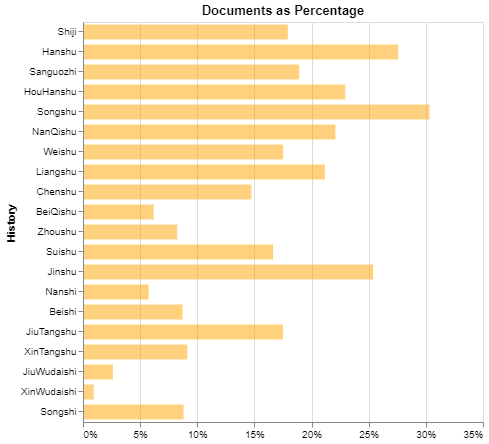

In [33]:
PercentageDocuments = alt.Chart(SummaryDf).mark_bar(color="orange", size=15, opacity=.5).encode(
        alt.Y('bookname', sort=HistoriesRegularized, title="History"),
        alt.X('DocPercentage', axis=alt.Axis(format='%'), title=''),
        tooltip=['bookname','DocPercentage']).properties(title="Documents as Percentage")

PercentageDocuments
#alt.Chart(SummaryDf).mark_bar(size=10, opacity=.5).encode(alt.Tooltip('DocPercentage', format='%'),
#        y=alt.Y('grandChar', sort=sortOrderBooks, title="Total length of book"),
#        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Documents as percent of whole')),color='bookname', )

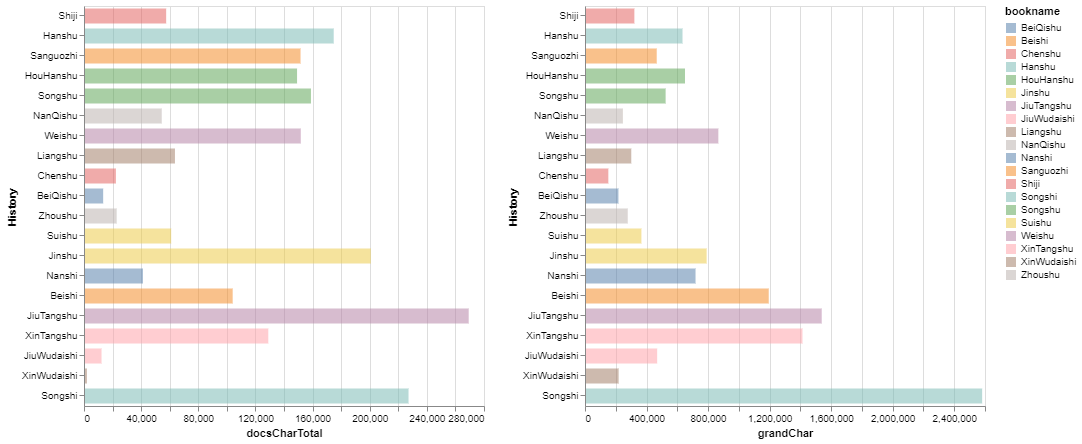

In [34]:
# first try, superceded by following cell.  Trying out `alt.repeat`.

alt.Chart(SummaryDf).mark_bar(size=15, opacity=.5).encode(
        alt.Y(alt.repeat('row'), type='nominal', sort=HistoriesRegularized, title="History"),
        alt.X(alt.repeat('column'), type='quantitative'),
        tooltip=['bookname','DocPercentage'], color='bookname').repeat(row=['bookname'], column=['docsCharTotal', 'grandChar'])
    

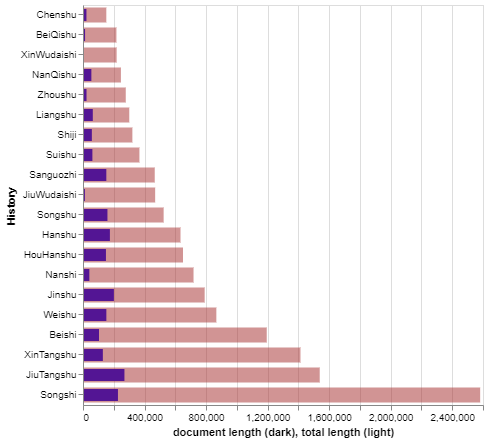

In [35]:
# total document length against total length of the biographies.
# NB "proportion" does not visually convey percentage comparison
# regular sort: HistoriesRegularized

totalLength = alt.Chart(SummaryDf).mark_bar(size=15, color='brown', opacity=.5).encode(alt.X('grandChar', title="total length (light)"), alt.Y('bookname', sort=alt.Sort(field="grandChar"), title="History"), tooltip = ["docsCharTotal:Q","grandChar:Q", "DocPercentage"])

totalDocLength = alt.Chart(SummaryDf).mark_bar(size=12, color='blue').encode(alt.X('docsCharTotal', title="document length (dark)"), alt.Y('bookname', sort=alt.Sort(field="grandChar")))

#alt.layer(totalDocLength, totalLength).properties(title="Documents as Proportion") | PercentageDocuments
alt.layer(totalDocLength, totalLength).properties()
#totalLength | totalDocLength

In [36]:
# deprecated method, or useful for some things?  charting inside a function.
def percentageDocByBook(df):
    dfPlot1 = pd.DataFrame({
        'book': df.index.to_numpy(),
        'DocPercentage': df['DocPercentage'].to_numpy()
    })
    return alt.Chart(dfPlot1).mark_bar().encode(
        y=alt.Y('book', sort=sortOrderBooks),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Document as Percent of Biographies'))
    )

In [37]:
DocPercentageRanked = alt.Chart(SummaryDf).mark_bar(color="teal").encode(
        y=alt.Y('bookname', sort=sortOrderPercent, title="History"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Document as Percent of Biographies')), 
    tooltip='DocPercentage'
    )
#color='bookname', 

In [38]:
DocPercentageList = alt.Chart(SummaryDf).mark_bar().encode(
        y=alt.Y('bookname', sort=HistoriesRegularized, title="History"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Document as Percent of Biographies')),
    tooltip='DocPercentage'
    )
#color='bookname', 

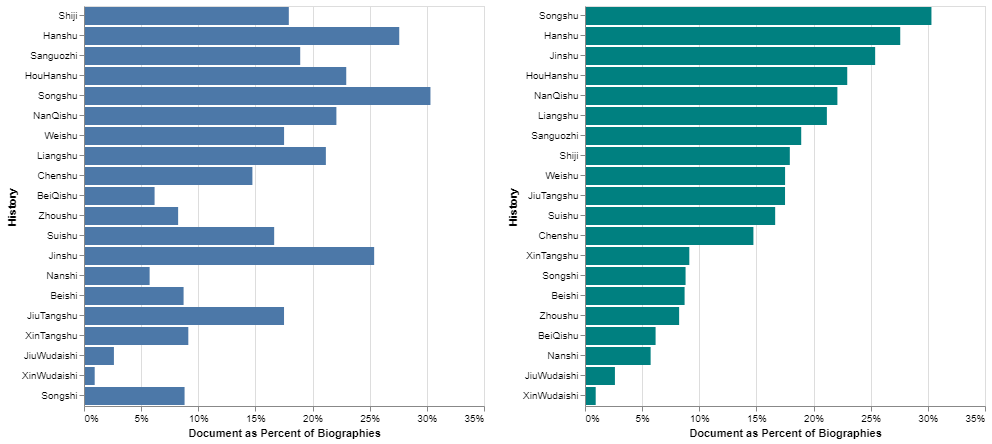

In [39]:
#DocPercentageRanked | DocPercentageList
alt.hconcat(DocPercentageList,DocPercentageRanked)

In [40]:
# cell for testing modifications of the Df

SummaryDfTry = SummaryDf.copy()



In [41]:
# MB, for now, using index values, not corrected forms in 'bookname' 
NorthernHistories = ["Weishu", "BeiQishu", "Zhoushu", "Beishi"]
SouthernHistories = ["Songshu", "Nanqishu", "LiangShu", "Chenshu"]
HanModels = ["Shiji", "Hanshu"]
FifthCentury = ["HouHanShu", "Songshu"]
JinAndSthnDy = ["Jinshu", "Songshu", "Nanqishu", "LiangShu", "Chenshu"]
notMedieval = ["XinTangshu", "JiuWudaishi", "XinWudaishi", "Songshi"]
TangHistoriography = ["Suishu", "Jinshu", "JiuTangshu"]
MajorComparisons = ["Shiji", "Hanshu", "HouHanShu", "Sanguozhi", "Songshu", "Nanqishu"]

In [42]:
# Use the reindex method to select data from the general dataframe
#SummaryDf.drop(columns="bookname")
SummaryDf.reindex(NorthernHistories)

#SummaryDf.index

,grandChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,commentaryChar,qDocsC,qDocsCharC,docsTotal,docsCharTotal,DocPercentage,bookname
book,,,,,,,,,,,,
Weishu,866751.0,76.0,79618.0,198.0,72124.0,0.0,0.0,0.0,274.0,151742.0,0.175070,Weishu
BeiQishu,217321.0,12.0,11259.0,8.0,2163.0,0.0,0.0,0.0,20.0,13422.0,0.061761,BeiQishu
Zhoushu,277868.0,35.0,21097.0,7.0,1788.0,0.0,0.0,0.0,42.0,22885.0,0.082359,Zhoushu
Beishi,1194214.0,111.0,79844.0,87.0,24222.0,0.0,0.0,0.0,198.0,104066.0,0.087142,Beishi


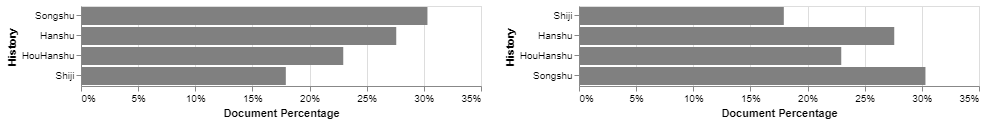

In [43]:
# Comparing 5th century histories to the Han model
reind1 = SummaryDf.reindex(set(FifthCentury+HanModels))

modelPercentSort1 = alt.Chart(reind1.reset_index()).mark_bar(color="gray").encode(alt.X(
    'DocPercentage', axis=alt.Axis(format='%'), title="Document Percentage"), alt.Y(
    'bookname:N', sort=sortOrderPercent, title='History'))

modelTimeSort1 = alt.Chart(reind1.reset_index()).mark_bar(color="gray").encode(alt.X(
    'DocPercentage', axis=alt.Axis(format='%'), title="Document Percentage"), alt.Y(
    'bookname:N', sort=["Shiji", "Hanshu", "HouHanshu", "Songshu"], title='History'))

modelPercentSort1 | modelTimeSort1


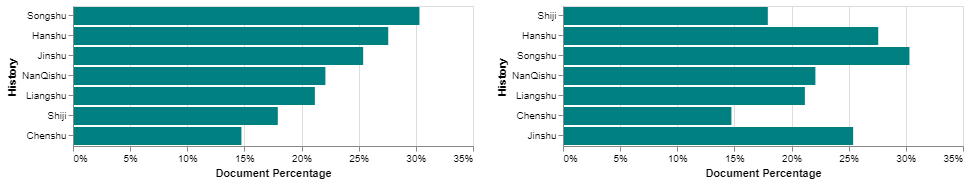

In [44]:
# Comparing 5th century histories to the Han model

reind2 = SummaryDf.reindex(set(JinAndSthnDy+HanModels))

modelPercentSort2 = alt.Chart(reind2.reset_index()).mark_bar(color="teal").encode(alt.X(
    'DocPercentage', axis=alt.Axis(format='%'), title="Document Percentage"), alt.Y(
    'bookname:N', sort=sortOrderPercent, title='History'))

modelTimeSort2 = alt.Chart(reind2.reset_index()).mark_bar(color="teal").encode(alt.X(
    'DocPercentage', axis=alt.Axis(format='%'), title="Document Percentage"), alt.Y(
    'bookname:N', sort=["Shiji", "Hanshu", "Songshu", "NanQishu", "Liangshu", "Chenshu"], title='History'))

modelPercentSort2 | modelTimeSort2


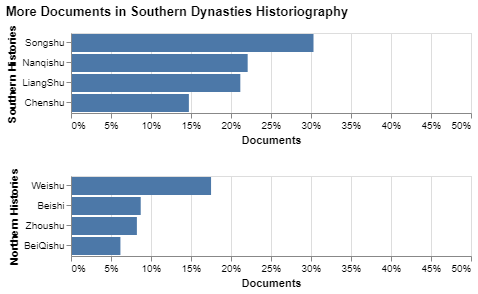

In [45]:
DocPercentageRankedNorth = alt.Chart(SummaryDf.reindex(NorthernHistories).reset_index()).mark_bar().encode(
        y=alt.Y('book', sort=sortOrderPercent, title="Northern Histories"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Documents'), scale=alt.Scale(domain=(0, .5)))
    )

DocPercentageRankedSouth = alt.Chart(SummaryDf.reindex(SouthernHistories).reset_index()).mark_bar().encode(
        y=alt.Y('book', sort=sortOrderPercent, title="Southern Histories"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Documents'), scale=alt.Scale(domain=(0, .5)))
    )

DocPercentageRankedMajor =  alt.Chart(SummaryDf.reindex(MajorComparisons).reset_index()).mark_bar().encode(
        y=alt.Y('book', sort=sortOrderPercent, title="History"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Document as Percent of Whole - Major Histories'), scale=alt.Scale(domain=(0, .5)))
    )



#DocPercentageRankedNorth & DocPercentageRankedSouth 
alt.vconcat(DocPercentageRankedSouth,DocPercentageRankedNorth).properties(
    title="More Documents in Southern Dynasties Historiography")


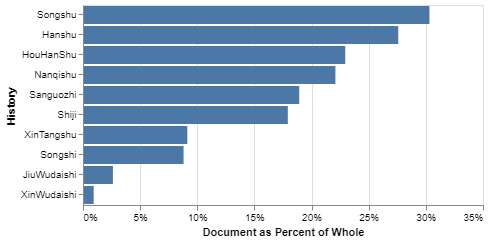

In [46]:
DocPercentageRankedMajorandnotMedieval =  alt.Chart(SummaryDf.reindex(set(notMedieval+MajorComparisons)).reset_index()).mark_bar().encode(
        y=alt.Y('book', sort=sortOrderPercent, title="History"),
        x=alt.X('DocPercentage', axis=alt.Axis(format='%', title='Document as Percent of Whole'))
    )

DocPercentageRankedMajorandnotMedieval

### Plot total document count and total document character count by scroll no. for a given book

- version 1, using book-specific dfs ("zz") within a defined function
- trying: to run `alt.repeat` over "dfBios"

In [47]:
dfBios.head()
#SummaryDf.head()
dfBios[:10]

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
149,Shiji,0149,61,列傳,1126,0,1,274,0,0,0,0,1,274,1125
150,Shiji,0150,62,列傳,654,0,0,0,0,0,0,0,0,0,654
151,Shiji,0151,62,列傳,692,0,0,0,0,0,0,0,0,0,692
152,Shiji,0152,63,列傳,658,0,0,0,0,0,0,0,0,0,658
153,Shiji,0153,63,列傳,293,0,0,0,0,0,0,0,0,0,293
154,Shiji,0154,63,列傳,91,0,0,0,0,0,0,0,0,0,91
155,Shiji,0155,63,列傳,254,0,0,0,0,0,0,0,0,0,254
156,Shiji,0156,63,列傳,1562,0,1,1145,0,0,0,0,1,1145,1561
157,Shiji,0157,64,列傳,1030,0,0,0,0,0,0,0,0,0,1030
158,Shiji,0158,65,列傳,1407,0,0,0,0,0,0,0,0,0,1407


# failed...

alt.Chart(dfBios[:1000]).mark_bar().encode(alt.X("scrollno:O"), alt.Y(alt.repeat("row"), type="nominal")).repeat(row=["book"])

In [48]:
# making specific dfs grouping by specific books

zz2 = dfBios[dfBios.book=='HouHanShu'].groupby('scrollno')['grandChar', 'iDocsM', 'iDocsCharM', 'qDocsM', 'qDocsCharM', 'commentaryChar', 'qDocsC', 'qDocsCharC'].sum()
zz2['DocPercentage'] = (zz2['iDocsCharM'] + zz2['qDocsCharM'] + zz2['qDocsCharC']) / (zz2['grandChar']  + zz2['commentaryChar'])                  
zz2.head(20)

,grandChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,commentaryChar,qDocsC,qDocsCharC,DocPercentage
scrollno,,,,,,,,,
11,7011,0,0,1,233,0,0,0,0.033233
12,6465,0,0,1,279,0,0,0,0.043155
13,9090,1,835,6,1663,0,0,0,0.274807
14,6125,0,0,1,203,0,0,0,0.033143
15,6688,0,0,1,202,0,0,0,0.030203
16,11143,1,1106,1,262,0,0,0,0.122768
17,9492,0,0,2,463,0,0,0,0.048778
18,7372,0,0,1,247,0,0,0,0.033505
19,8042,0,0,1,222,0,0,0,0.027605


In [49]:
# narrowed down to chart3
# added common "scale" parameter to Y-axis
def chartDocsByScroll(df, book):

    zz = df[df.book==book].groupby('scrollno')['grandChar', 'iDocsM', 'iDocsCharM', 'qDocsM', 'qDocsCharM', 'commentaryChar', 'qDocsC', 'qDocsCharC'].sum()
    zz['DocPercentage'] = (zz['iDocsCharM'] + zz['qDocsCharM'] + zz['qDocsCharC']) / (zz['grandChar']  + zz['commentaryChar'])                  

    # doc count
    dfPlot1 = pd.DataFrame({
        'scrollno': zz.index.to_numpy(),
        'Docs': zz['iDocsM'].to_numpy() + zz['qDocsM'].to_numpy() + zz['qDocsC'].to_numpy()
    })
    chart1 = alt.Chart(dfPlot1).mark_bar().encode(
        y=alt.Y('Docs:Q', axis=alt.Axis(format='', title='Total Document Count \n(indented+quoted) by Scroll'), scale=alt.Scale(domain=(0,1))),
        x='scrollno:O'
    )
    # doc character count
    dfPlot2 = pd.DataFrame({
        'scrollno': zz.index.to_numpy(),
        'DocsChar': zz['iDocsCharM'].to_numpy() + zz['qDocsCharM'].to_numpy() + zz['qDocsCharC'].to_numpy()
    })
    chart2 = alt.Chart(dfPlot2).mark_bar().encode(
        y=alt.Y('DocsChar:Q', axis=alt.Axis(format='', title='Total Document Character Count (indented+quoted) by Scroll'), scale=alt.Scale(domain=(0,1))),
        x='scrollno:O'
    )
    # doc character % as total main text
    dfPlot3 = pd.DataFrame({
        'scrollno': zz.index.to_numpy(),
        'DocsPercent': (zz['iDocsCharM'].to_numpy() + zz['qDocsCharM'].to_numpy()  + zz['qDocsCharC'].to_numpy()) / \
                        (zz['grandChar'].to_numpy() + zz['commentaryChar'].to_numpy())
    })
    chart3 = alt.Chart(dfPlot3).mark_bar().encode(
        y=alt.Y('DocsPercent:Q', axis=alt.Axis(format='%', title='Document %'), scale=alt.Scale(domain=(0,.75))),
        x=alt.X('scrollno:O', axis=alt.Axis(title="Scroll number")), tooltip=["scrollno", "DocsPercent:Q"]
    )
    
    #return alt.vconcat(chart1, chart2, chart3)
    return chart3

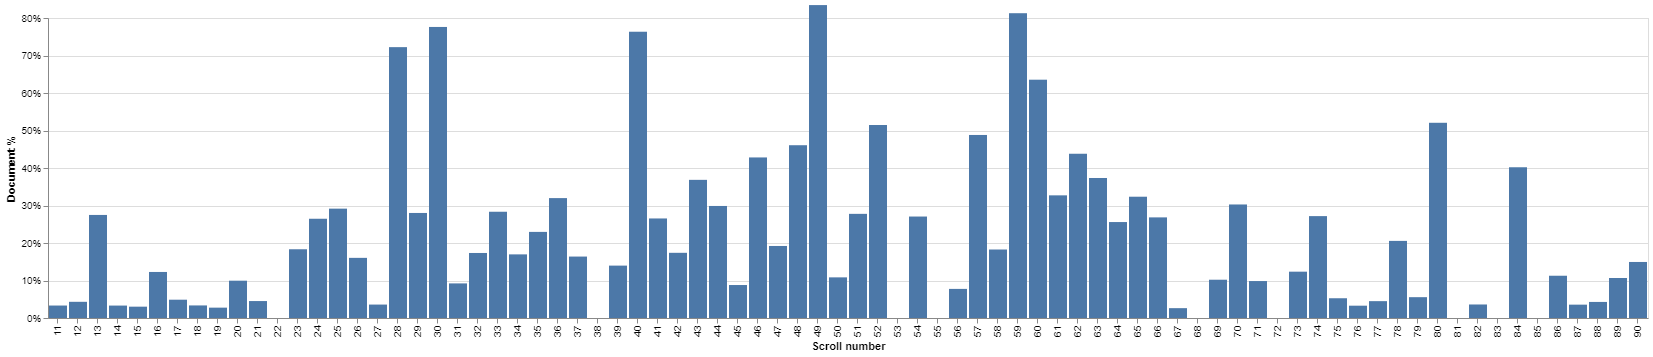

In [50]:
chartDocsByScroll(dfBios, 'HouHanShu')

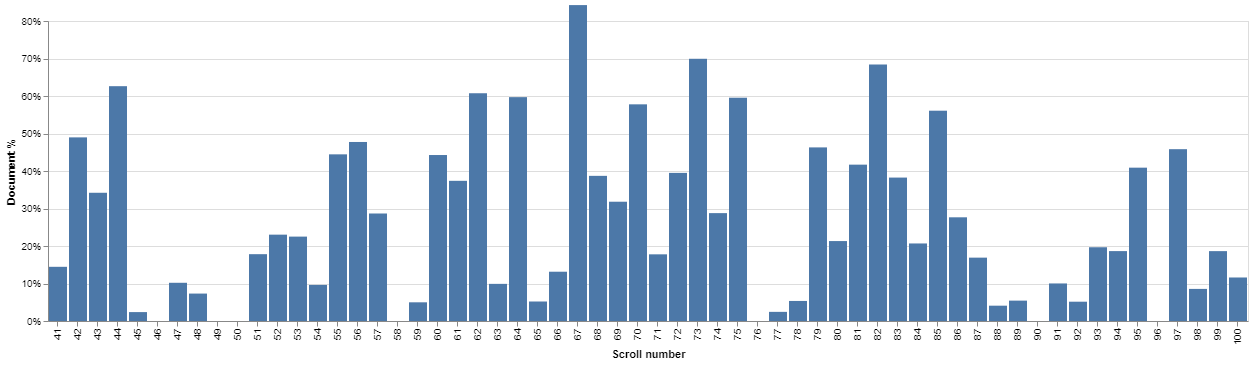

In [51]:
chartDocsByScroll(dfBios, 'Songshu')

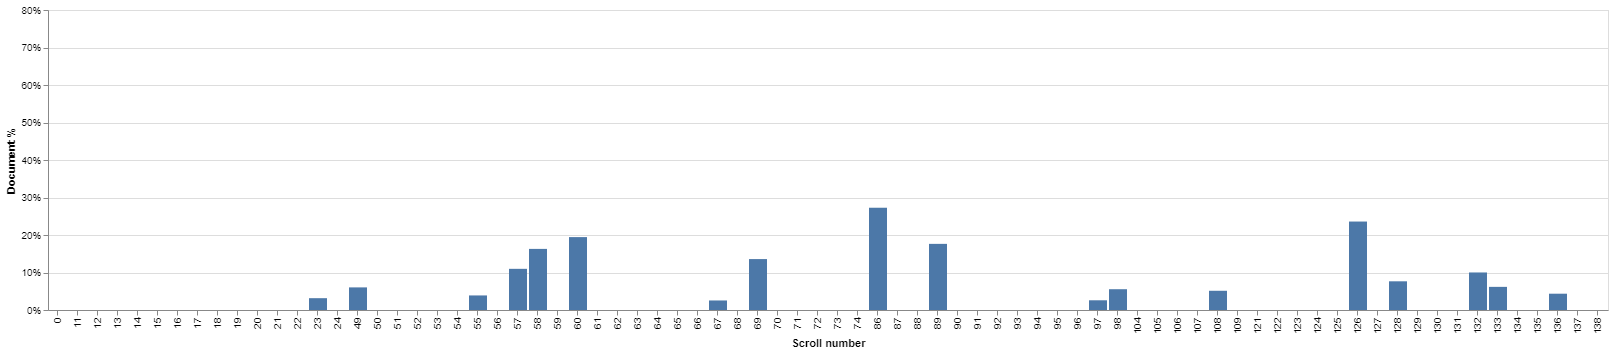

In [52]:
chartDocsByScroll(dfBios, "JiuWudaishi")

In [53]:
#look for a particular scroll number. Scroll 67 seems anomalously high, at over 80% document.
df[ (df.book=="Songshu") & (df.scrollno == 67)]

,book,fileno,scrollno,section,grandChar,commentaryChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,qDocsC,qDocsCharC,docsTotal,docsCharTotal,regTextMCharTotal
3674,Songshu,0749,67,列傳,20415,0,3,16802,1,396,0,0,4,17198,20411


In [54]:
#inspect it.  It is Xie Lingyun -- not an error.
#Books[Histories.index("Songshu")][749]


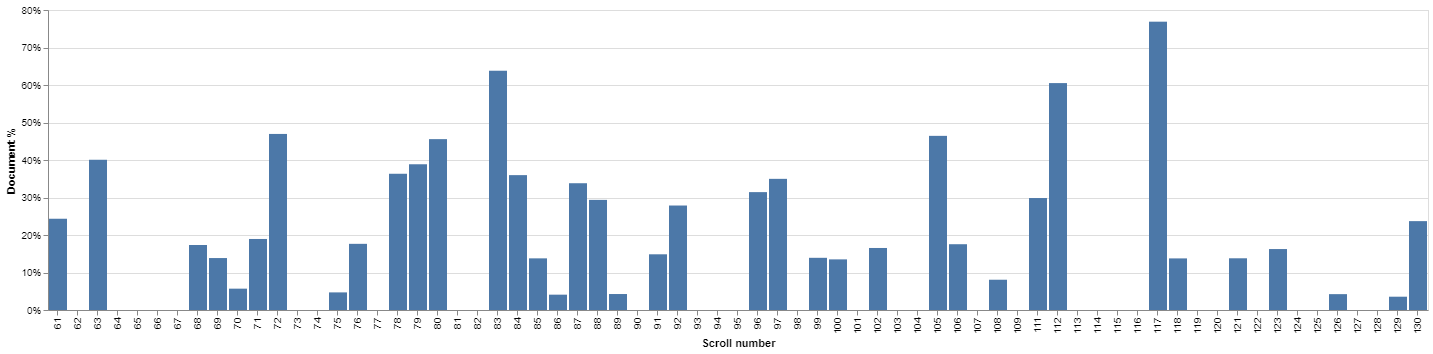

In [55]:
chartDocsByScroll(dfBios, 'Shiji')

In [56]:
# done: this and following cell written into a simple function, `specimenCheck`
q = df[ (df.book=="Shiji") & (df.scrollno == 117)]
list(q["fileno"])

['0332', '0333', '0334']

In [ ]:
#Books[Histories.index("Shiji")][332]
Books[Histories.index("Shiji")].pretty_print(332)

In [58]:
def specimenCheck(book, scroll, df=dfBios, printing=True):
    """book (string) is bookname (NB pinyin irregularities). scroll (int) is the scroll number to check.
    Returns file number and shows text if printing=True
    NB: function must change if variables 'Histories'/'Books' in ipynb are changed
    NB: pretty_print uses Book definition"""
    xiaodf = df[ (df.book==book) & (df.scrollno == scroll)]
    filenumbers = list(xiaodf["fileno"])
    #print(xiaodf)
    print("Htmls: ", filenumbers)
    if printing==True:
        printlist = []
        for html in filenumbers:
            html=int(html)
            printlist.append(Books[Histories.index(book)].pretty_print(html))
        return [item for item in printlist]
    else:
        return xiaodf["fileno"]


In [117]:
#specimenCheck("Shiji", 117)

In [60]:
# trying to run function over several books: throws no error, but doesn't render
# saving as html works (must be online)
# saving as png or svg throws "chromedriver" error
# temporary solution: create this list then insert values manually...

counter = 1
listofCharts = []
for item in SummaryDf.index:
    #print(counter, item)
    # chartDocsByScroll(dfBios, item) # won't display, but no error
    x = chartDocsByScroll(dfBios, item) 
    #x.save(f"../visualizations/scrollTry2/scrollviz-{item}.html") # works
    #x.save(f"../visualizations/scrollTry2/scrollviz-{item}.png") # error
    listofCharts.append([item, x])
    #counter+=1
len(listofCharts)

20

In [61]:
#listofCharts[0][0] 'bookname'
#listofCharts[0][1] chart

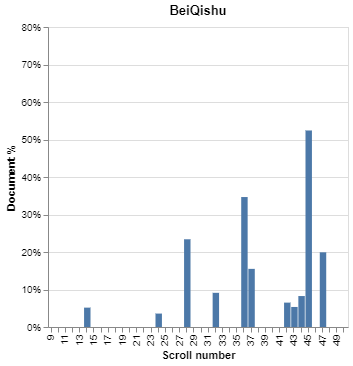

In [62]:
# what we want to repeat
listofCharts[0][1].properties(width=300, title=listofCharts[0][0])

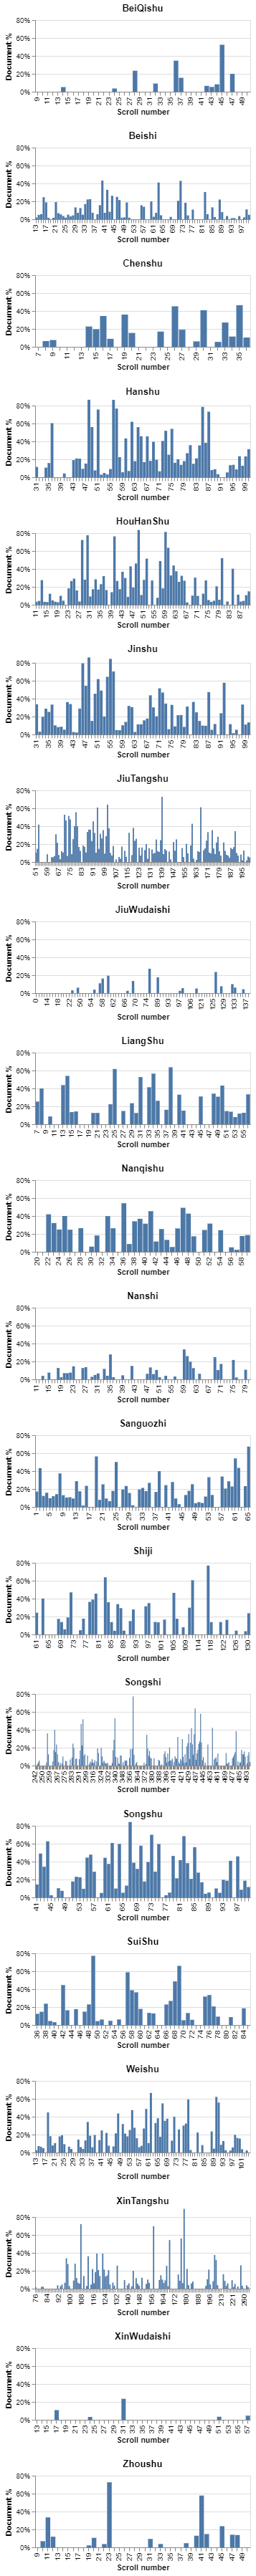

In [63]:
# manually...
# attempts to automate below
widthparam = 300
heightparam = 100

listofCharts[0][1].properties(width=widthparam, height=heightparam, title=listofCharts[0][0]) & \
listofCharts[1][1].properties(width=widthparam, height=heightparam, title=listofCharts[1][0]) & \
listofCharts[2][1].properties(width=widthparam, height=heightparam, title=listofCharts[2][0]) & \
listofCharts[3][1].properties(width=widthparam, height=heightparam, title=listofCharts[3][0]) & \
listofCharts[4][1].properties(width=widthparam, height=heightparam, title=listofCharts[4][0]) & \
listofCharts[5][1].properties(width=widthparam, height=heightparam, title=listofCharts[5][0]) & \
listofCharts[6][1].properties(width=widthparam, height=heightparam, title=listofCharts[6][0]) & \
listofCharts[7][1].properties(width=widthparam, height=heightparam, title=listofCharts[7][0]) & \
listofCharts[8][1].properties(width=widthparam, height=heightparam, title=listofCharts[8][0]) & \
listofCharts[9][1].properties(width=widthparam, height=heightparam, title=listofCharts[9][0]) & \
listofCharts[10][1].properties(width=widthparam, height=heightparam, title=listofCharts[10][0]) & \
listofCharts[11][1].properties(width=widthparam, height=heightparam, title=listofCharts[11][0]) & \
listofCharts[12][1].properties(width=widthparam, height=heightparam, title=listofCharts[12][0]) & \
listofCharts[13][1].properties(width=widthparam, height=heightparam, title=listofCharts[13][0]) & \
listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) & \
listofCharts[15][1].properties(width=widthparam, height=heightparam, title=listofCharts[15][0]) & \
listofCharts[16][1].properties(width=widthparam, height=heightparam, title=listofCharts[16][0]) & \
listofCharts[17][1].properties(width=widthparam, height=heightparam, title=listofCharts[17][0]) & \
listofCharts[18][1].properties(width=widthparam, height=heightparam, title=listofCharts[18][0]) & \
listofCharts[19][1].properties(width=widthparam, height=heightparam, title=listofCharts[19][0]) 

#### notes on scroll comparison charts
- problem with JiuWudaishi data selection?  fixed with correction to numbers, right?

In [64]:
# checking on scrolls with high document percentage

#specimenCheck("BeiQishu", 45) #文苑: 祖鴻勳,顏之推
#specimenCheck("Beishi", 40) #韓麒麟,sons,李彪
#specimenCheck("Beishi", 72) #牛弘
#specimenCheck("Beishi", 63) #蘇綽

#specimenCheck("Jinshu", 46) #劉頌
#specimenCheck("Jinshu", 48) #段灼,閻纘
#specimenCheck("Jinshu", 55) #夏侯湛,潘岳
#specimenCheck("JiuTangshu", 139) #陸贄
#specimenCheck("JiuTangshu", 190) #includes杜甫(only Yuan Zhen quote)
##specimenCheck("JiuTangshu", 180) #(sanity check)
#specimenCheck("JiuWudaishi", 0) #(sanity: problem mostly fixed in Book2 revision)
#specimenCheck("Shiji", 101) #(sanity check: 101-109 empty, combined with 110-190)
#specimenCheck("Songshi", 359) #李綱
#specimenCheck("SuiShu", 49) #牛弘
#specimenCheck("Weishu", 110) #(sanity)
#specimenCheck("XinTangshu", 178) #劉蕡
#specimenCheck("Zhoushu", 23) #蘇綽


### attempts to loop with Altair charts...

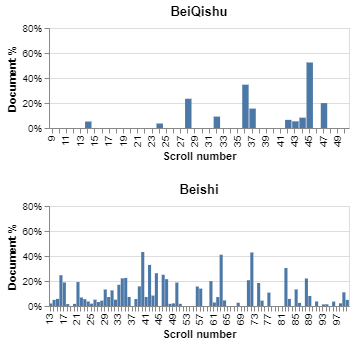

In [65]:
#this works, but how to loop??
i=1
listofCharts[0][1].properties(width=widthparam, height=heightparam, title=listofCharts[0][0]) & \
listofCharts[i][1].properties(width=widthparam, height=heightparam, title=listofCharts[i][0])

In [66]:
# try: just create an altair concatenation string
# doesn't work
altConcat = ""
for i in range (20):
    chartobject = ""
    chartobject = listofCharts[i][1].properties(width=300, title=listofCharts[i][0])
    altConcat+=str(chartobject)
#print(altConcat)

In [67]:
#doesn't work
for i in range(1):
    #print(i)
    chartobject = listofCharts[i][1]
    chartobject.properties(width=50)

In [68]:
#doesn't work
i = 0
while i <20:
    listofCharts[i][1].properties(width=300)
    i+=1

In [ ]:
# doesn't work
for item in listofCharts:
    print(item[0])
    item[1]
    print("/n", "/n")

### tried: document percentage by file number (modified from scroll)
- in theory this should reflect individual biographies, and avoid hidden bugs in our collection of scroll numbers.
- discount: files are sometimes biographies, but sometimes parts of biographies. Clustered peaks show biographies with several documents.  This could be useful.
    - could be used to weed out and change false positives.  E.g., in Songshi, first peak (though that is neglible in terms of character count)
- note also chart2, for document character count

In [70]:
# from chartDocsbyScroll, winnowed down and modified for file number (html)

def chartDocsByFile(df, book, chart2=False):

    zz = df[df.book==book].groupby('fileno')['grandChar', 'iDocsM', 'iDocsCharM', 'qDocsM', 'qDocsCharM', 'commentaryChar', 'qDocsC', 'qDocsCharC'].sum()
    zz['DocPercentage'] = (zz['iDocsCharM'] + zz['qDocsCharM'] + zz['qDocsCharC']) / (zz['grandChar']  + zz['commentaryChar'])                  

    # doc count
    dfPlot1 = pd.DataFrame({
        'fileno': zz.index.to_numpy(),
        'Docs': zz['iDocsM'].to_numpy() + zz['qDocsM'].to_numpy() + zz['qDocsC'].to_numpy()
    })
    chart1 = alt.Chart(dfPlot1).mark_bar().encode(
        y=alt.Y('Docs:Q', axis=alt.Axis(format='', title='Total Document Count \n(indented+quoted) per file'), scale=alt.Scale(domain=(0,1))),
        x='fileno:O'
    )
    # doc character count
    dfPlot2 = pd.DataFrame({
        'fileno': zz.index.to_numpy(),
        'DocsChar': zz['iDocsCharM'].to_numpy() + zz['qDocsCharM'].to_numpy() + zz['qDocsCharC'].to_numpy()
    })
    chart2 = alt.Chart(dfPlot2).mark_bar().encode(
        y=alt.Y('DocsChar:Q', axis=alt.Axis(format='', title='Total Document Character Count (indented+quoted) per file'), scale=alt.Scale(domain=(0,10))),
        x='fileno:O'
    )
    # doc character % as total main text
    dfPlot3 = pd.DataFrame({
        'fileno': zz.index.to_numpy(),
        'DocsPercent': (zz['iDocsCharM'].to_numpy() + zz['qDocsCharM'].to_numpy()  + zz['qDocsCharC'].to_numpy()) / \
                        (zz['grandChar'].to_numpy() + zz['commentaryChar'].to_numpy())
    })
    chart3 = alt.Chart(dfPlot3).mark_bar().encode(
        y=alt.Y('DocsPercent:Q', axis=alt.Axis(format='%', title='Document %'), scale=alt.Scale(domain=(0,.75))),
        x=alt.X('fileno:O', axis=alt.Axis(title="file number")), tooltip=["fileno", "DocsPercent:Q"]
    )
    
    #return alt.vconcat(chart1, chart2, chart3)
    # return chart2 #will break when producing whole set, at least
    return chart3

In [71]:
counter = 1
listofChartsFile = []
for item in SummaryDf.index:
    x = chartDocsByFile(dfBios, item) 
    #x.save(f"../visualizations/fileTry2/fileviz-{item}.html") # works
    listofChartsFile.append([item, x])
    #counter+=1
len(listofChartsFile)

20

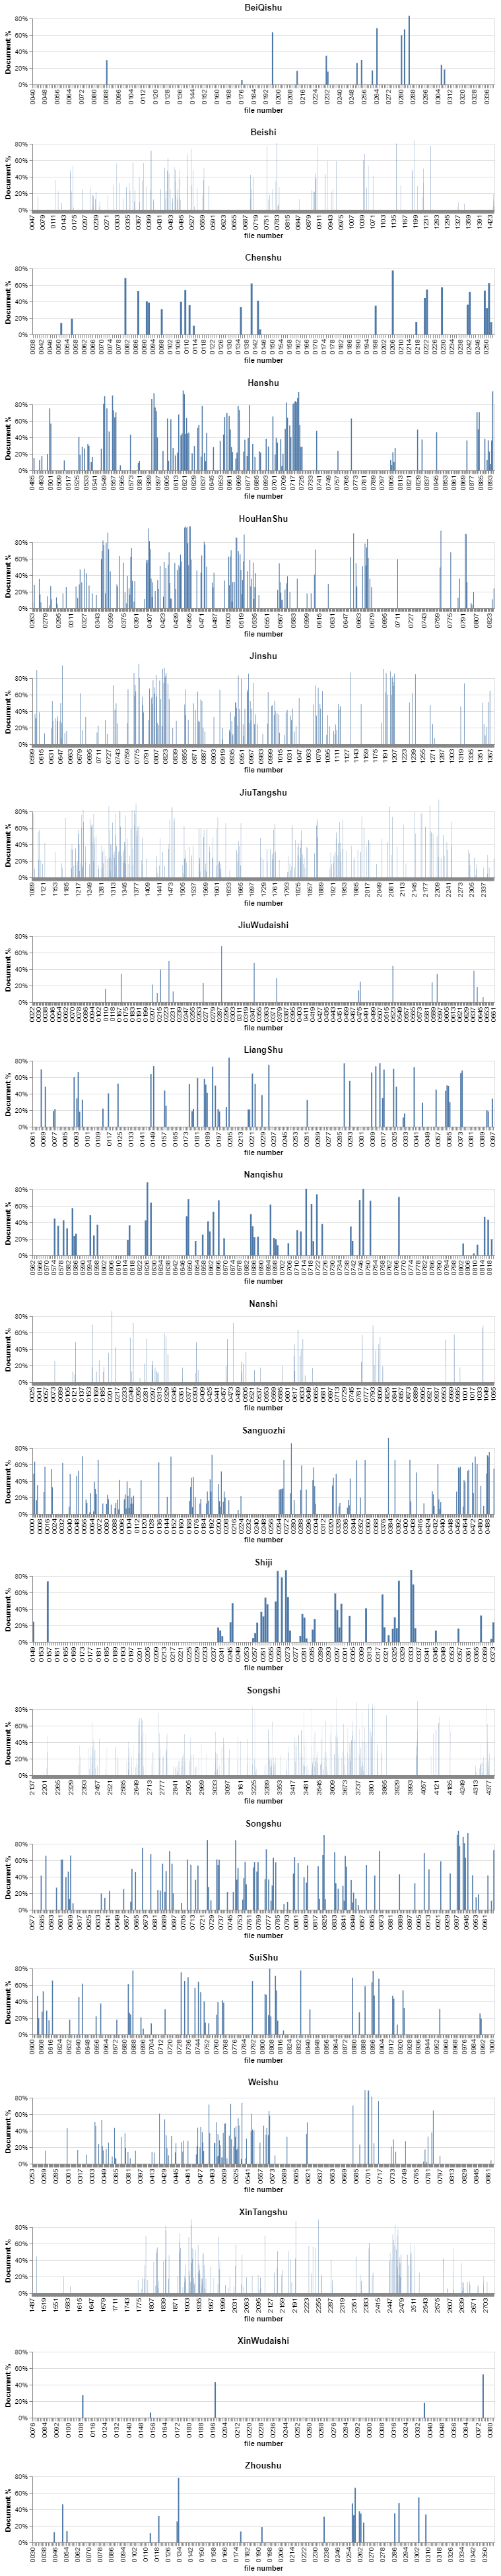

In [72]:
widthparam = 700
heightparam = 100

listofChartsFile[0][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[0][0]) & \
listofChartsFile[1][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[1][0]) & \
listofChartsFile[2][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[2][0]) & \
listofChartsFile[3][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[3][0]) & \
listofChartsFile[4][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[4][0]) & \
listofChartsFile[5][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[5][0]) & \
listofChartsFile[6][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[6][0]) & \
listofChartsFile[7][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[7][0]) & \
listofChartsFile[8][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[8][0]) & \
listofChartsFile[9][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[9][0]) & \
listofChartsFile[10][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[10][0]) & \
listofChartsFile[11][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[11][0]) & \
listofChartsFile[12][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[12][0]) & \
listofChartsFile[13][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[13][0]) & \
listofChartsFile[14][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[14][0]) & \
listofChartsFile[15][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[15][0]) & \
listofChartsFile[16][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[16][0]) & \
listofChartsFile[17][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[17][0]) & \
listofChartsFile[18][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[18][0]) & \
listofChartsFile[19][1].properties(width=widthparam, height=heightparam, title=listofChartsFile[19][0]) 

In [73]:
def callFile (book, fileno):
    #return Books[HI(book)].flat_bodies[fileno]
    return (print("metainfo: ", Books[HI(book)].paths[fileno]), Books[HI(book)].pretty_print(fileno))

In [74]:
callFile("JiuWudaishi", 289)

metainfo:  史／正史／舊五代史／唐書　凡五十卷／列傳／卷六十九　唐書四十五　列傳第二十一／張延朗(P.919)..[底本：南昌熊氏曾影庫本]


(None, None)

### breaking up the scroll charts

#full list
widthparam = 300
heightparam = 100

listofCharts[0][1].properties(width=widthparam, height=heightparam, title=listofCharts[0][0]) & \
listofCharts[1][1].properties(width=widthparam, height=heightparam, title=listofCharts[1][0]) & \
listofCharts[2][1].properties(width=widthparam, height=heightparam, title=listofCharts[2][0]) & \
listofCharts[3][1].properties(width=widthparam, height=heightparam, title=listofCharts[3][0]) & \
listofCharts[4][1].properties(width=widthparam, height=heightparam, title=listofCharts[4][0]) & \
listofCharts[5][1].properties(width=widthparam, height=heightparam, title=listofCharts[5][0]) & \
listofCharts[6][1].properties(width=widthparam, height=heightparam, title=listofCharts[6][0]) & \
listofCharts[7][1].properties(width=widthparam, height=heightparam, title=listofCharts[7][0]) & \
listofCharts[8][1].properties(width=widthparam, height=heightparam, title=listofCharts[8][0]) & \
listofCharts[9][1].properties(width=widthparam, height=heightparam, title=listofCharts[9][0]) & \
listofCharts[10][1].properties(width=widthparam, height=heightparam, title=listofCharts[10][0]) & \
listofCharts[11][1].properties(width=widthparam, height=heightparam, title=listofCharts[11][0]) & \
listofCharts[12][1].properties(width=widthparam, height=heightparam, title=listofCharts[12][0]) & \
listofCharts[13][1].properties(width=widthparam, height=heightparam, title=listofCharts[13][0]) & \
listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) & \
listofCharts[15][1].properties(width=widthparam, height=heightparam, title=listofCharts[15][0]) & \
listofCharts[16][1].properties(width=widthparam, height=heightparam, title=listofCharts[16][0]) & \
listofCharts[17][1].properties(width=widthparam, height=heightparam, title=listofCharts[17][0]) & \
listofCharts[18][1].properties(width=widthparam, height=heightparam, title=listofCharts[18][0]) & \
listofCharts[19][1].properties(width=widthparam, height=heightparam, title=listofCharts[19][0]) 

In [75]:
# how is Histories sorted?  I seem to have broken HI and associated functions by sorting it...
[(Histories.index(entry), entry) for entry in Histories]

[(0, 'Shiji'),
 (1, 'Hanshu'),
 (2, 'Sanguozhi'),
 (3, 'HouHanShu'),
 (4, 'Songshu'),
 (5, 'Nanqishu'),
 (6, 'Weishu'),
 (7, 'LiangShu'),
 (8, 'Chenshu'),
 (9, 'BeiQishu'),
 (10, 'Zhoushu'),
 (11, 'SuiShu'),
 (12, 'Jinshu'),
 (13, 'Nanshi'),
 (14, 'Beishi'),
 (15, 'JiuTangshu'),
 (16, 'XinTangshu'),
 (17, 'JiuWudaishi'),
 (18, 'XinWudaishi'),
 (19, 'Songshi')]

#### what do you want to compare?
- Songshu (lots) and Nanshi (slim) (14, 10)
- Songshu and Weishu (northern historiography more dispersed)? (14, 16)
- Songshu and Hanshu (high frequency = similar pattern?) (14, 3)
- the medieval ones (4, 11, 5, 14, 9, 8, 2, 15)
- the two models, Shiji and Hanshu (12, 3)
- (for fun) Jts and Xts (6, 17)
- Songshi and Hanshu (13, 3)

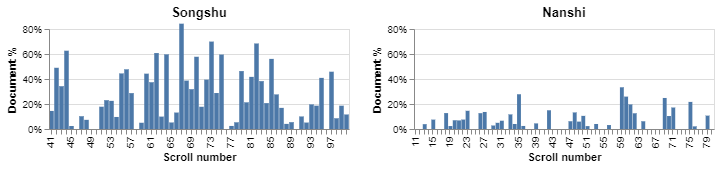

In [76]:
# Songshu and Nanshi
# "lower buildings" and (somewhat? check with chart1 docCount view?) sparser "population"

widthparam = 300
heightparam = 100

listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) | \
listofCharts[10][1].properties(width=widthparam, height=heightparam, title=listofCharts[10][0])

In [164]:
#specimenCheck("Nanshi", 59) # Jiang Yan, Ren Fang, and (no docs) Wang Sengda
#specimenCheck("Nanshi", 35)  #Yu Zhongwen, Gu Xianzhi; an unassuming 27%

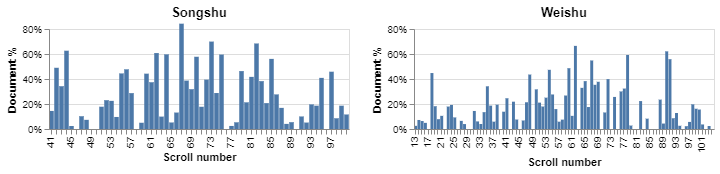

In [77]:
# Songshu and Weishu

widthparam = 300
heightparam = 100

listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) | \
listofCharts[16][1].properties(width=widthparam, height=heightparam, title=listofCharts[16][0])

In [78]:
#specimenCheck("Weishu", 90) #Li Mi
#specimenCheck("Weishu", 18) #Tuoba Shen

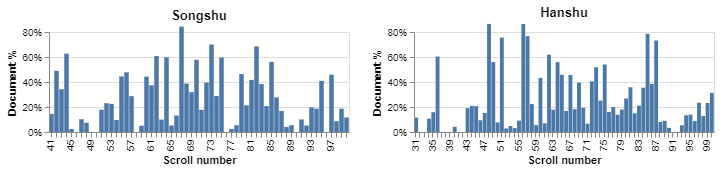

In [79]:
# Songshu and Hanshu

widthparam = 300
heightparam = 100

listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) | \
listofCharts[3][1].properties(width=widthparam, height=heightparam, title=listofCharts[3][0])

In [158]:
#specimenCheck("Hanshu", 48) #Jia Yi
#specimenCheck("Hanshu", 56) #Dong Zhongshu
#specimenCheck("Hanshu", 85) #Gu Yong, Du Ye
#specimenCheck("Hanshu", 87) #Yang Xiong
#specimenCheck("Hanshu", 57) #Sima Xiangru
#specimenCheck("Hanshu", 51) #Jia Shan, Zou Yang
#specimenCheck("Hanshu", 100) #Ban Biao, Ban Gu
#specimenCheck("Songshu", 73) # Yan Yanzhi
#specimenCheck("Songshu", 67) # XLY
#specimenCheck("Songshu", 44) # Xie Hui
#specimenCheck("Songshu", 75) #Wang Sengda
#specimenCheck("Songshu", 76) # Zhu Xiuzhi, Zong Que, Wang Xuanmo

#some comparisons: note that Hanshu is 70 bios, Songshu only 60
#Hanshu over 60%: 8, vs. Songshu:5
#Songshu in 40-60% range: 12, vs. Hanshu: 7
#Songshu 20-40%: 13, Hanshu: 15


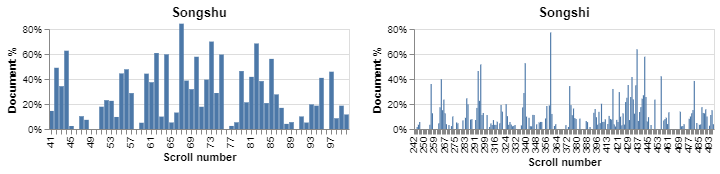

In [81]:
# Songshu and Songshi

widthparam = 300
heightparam = 100

listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) | \
listofCharts[13][1].properties(width=widthparam, height=heightparam, title=listofCharts[13][0])

In [165]:
#observation: Songshi especially on border affairs.  
#Songshi: Still contains two over 60% (Li Gang and Chen Liang), 6 between 40% and 60%, and 22 between 20 and 40%


#specimenCheck("Songshi", 359) # Li Gang; but this is only the second half of his bio, 358 is 18%, for mean of 48%
#specimenCheck("Songshi", 358)
#specimenCheck("Songshi", 293) #Tian Xi, Wang Yucheng
#specimenCheck("Songshi", 295) # Yin Zhu, Xie Jiang, Ye Qingchen
#specimenCheck("Songshi", 436) # Chen Liang
#specimenCheck("Songshi", 442) #Su Shunqin
#specimenCheck("Songshi", 339) #Su Che
#specimenCheck("Songshi", 429) # Zhu Xi
#specimenCheck("Songshi", 432) # various Rulin
#specimenCheck("Songshi", 256) # Zhao Pu and brother Zhao Anyi
#specimenCheck("Songshi", 248) # princesses: formatting error [now fixed]
#specimenCheck("Songshi", 264) # Song Qi, two long memorials on border affairs


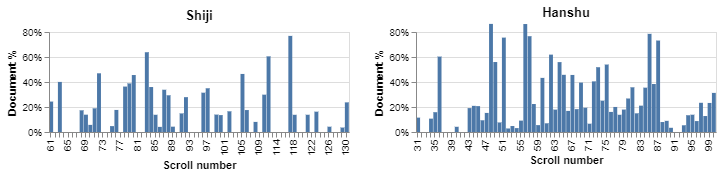

In [83]:
# Shiji and Hanshu.  Hanshu simply has a more ample stock

widthparam = 300
heightparam = 100

listofCharts[12][1].properties(width=widthparam, height=heightparam, title=listofCharts[12][0]) | \
listofCharts[3][1].properties(width=widthparam, height=heightparam, title=listofCharts[3][0])

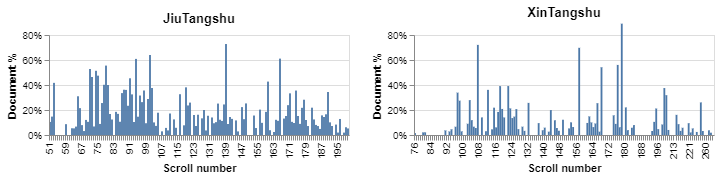

In [84]:
# Jts and Xts
# higher peaks in XinTangshu, but denser and higher overall percentage in XinTangshu.

widthparam = 300
heightparam = 100

listofCharts[6][1].properties(width=widthparam, height=heightparam, title=listofCharts[6][0]) | \
listofCharts[17][1].properties(width=widthparam, height=heightparam, title=listofCharts[17][0])

In [85]:
#specimenCheck("XinTangshu", 178) # Liu Bi 劉蕡
#specimenCheck("XinTangshu", 107) # Fu Yi, Lv Cai, Chen Ziang

In [86]:
Books[HI("XinTangshu")].paths[1751]

'史／正史／新唐書／列傳\u3000凡一百五十卷／卷八十八\u3000列傳第十三／劉文靜(P.3733)..[底本：北宋嘉祐十四行本]'

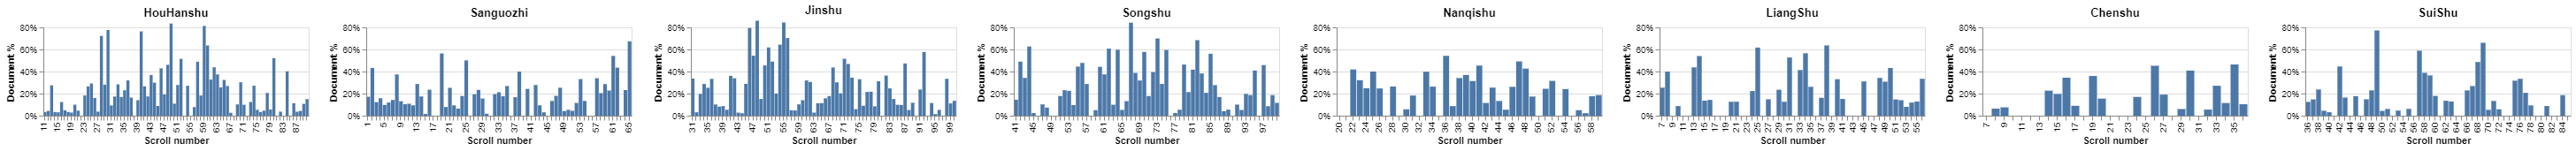

In [87]:
# medieval histories : 4, 11, 5, 14, 9, 8, 2, 15

widthparam = 300
heightparam = 100

listofCharts[4][1].properties(width=widthparam, height=heightparam, title="HouHanshu") | \
listofCharts[11][1].properties(width=widthparam, height=heightparam, title=listofCharts[11][0]) | \
listofCharts[5][1].properties(width=widthparam, height=heightparam, title=listofCharts[5][0]) | \
listofCharts[14][1].properties(width=widthparam, height=heightparam, title=listofCharts[14][0]) | \
listofCharts[9][1].properties(width=widthparam, height=heightparam, title=listofCharts[9][0]) | \
listofCharts[8][1].properties(width=widthparam, height=heightparam, title=listofCharts[8][0]) | \
listofCharts[2][1].properties(width=widthparam, height=heightparam, title=listofCharts[2][0]) | \
listofCharts[15][1].properties(width=widthparam, height=heightparam, title=listofCharts[15][0])

In [88]:
# observations on medieval histories charts
# HouHanshu has high several "skyscrapers"
# Jinshu has some early skyscrapers (46, 48, 55).  92 is Wenyuan
# No skyscrapers in NanQishu -- nothing over 60%.  This makes an interesting contrast with the 
# Liangshu, which has twice as many over 40% but fewer in the lower ranges.

In [176]:
#SummaryDf
#specimenCheck("HouHanShu", 28) # Huan Tan, Feng Yan
#specimenCheck("HouHanShu", 30) # Su Jing, Lang Kai (et al)
#specimenCheck("HouHanShu", 40) # Ban Biao, Ban Gu
#specimenCheck("HouHanShu", 49) # Wang Chong (no docs), Wang Fu (five essays), Zhongchang Tong (two poems, essays)
#specimenCheck("HouHanShu", 59) # Zhang Heng (dialogue, Sixuan fu)
#specimenCheck("HouHanShu", 60) # Ma Rong (Guangcheng song) and Cai Yong (釋誨 dialogue, policy essays, personal statements)
#specimenCheck("HouHanShu", 80) # literary bios, incl. Du Du capital rhapsody, Fu Yi poem, 崔琦 admonition on empress 
    # families, Zhao Yi letter and rhapsody, Bian Rang rhapsody, Li Yan poem
#specimenCheck("HouHanShu", 84) # women lienv. Ban Zhao admonition, Cai Yan two poems
#specimenCheck("HouHanShu", 52) # grandfather Cui Zhuan "Weizhi 慰志 fu", protagonist Cui Yin dialogue and letter,
    # grandson Cui Shi policy essay. 52%.


In [177]:
#specimenCheck("Jinshu", 46) # Liu Song and Li Chong
#specimenCheck("Jinshu", 48) # Duan Zhuo and Yan Zuan
#specimenCheck("Jinshu", 55) # Xiaohou Zhan (dialogue, and 'gao' for brothers)
#specimenCheck("Jinshu", 92) # Wenyuan
#specimenCheck("SuiShu", 49) # Niu Hong (bibliography, mingtang, music)
#specimenCheck("SuiShu", 69) # Wang Shao and Yuan Chong (omens)
#specimenCheck("SuiShu", 57) # Lu Sidao (孤鴻賦, dialogue), Xue Daoheng (ironic encomium)
#specimenCheck("Chenshu", 35) # central gov't accusations of 'rebels'
#specimenCheck("Chenshu", 26) # Xu Ling (long letter)
#specimenCheck("Chenshu", 19) # Yu Ji (protest letter in Chen Baoying 'rebellion')
#specimenCheck("LiangShu", 38) # He Chen (ritual, but also memorial and emperor's indignant response)
#specimenCheck("LiangShu", 25) # Xu Mian (ritual memorial, but also admonition letter to son and dialogs)
#specimenCheck("Songshu", 75) # Wang Sengda (subjectivity in memorials), Yan Jun (monetary policy, but still specimens of rhetoric, illustrating his "bi" talents)
#specimenCheck("Nanshi", 22) # Wang Sengqian et al
#specimenCheck("Nanqishu", 36) # Xie Chaozong (accusations against), Liu Xiang ("lianzhu" series, accusations against)
#specimenCheck("Nanqishu", 59) # foreign tribes
#specimenCheck("Songshu", 99) # the two rebels
#specimenCheck("Songshu", 97) # southwestern nations, and a Buddhist treatise.
#specimenCheck("Songshu", 85) # Xie Zhuang (political, policy, and 'personal but tied to bureaucratic problem' memorials, rhapsody on dancing horses),
    # and Wang Jingwen (memorial and edict in response)
#specimenCheck("Songshu", 77) # military men. only 2% docs

### Build some vocabulary lists

In [185]:
# use these 'sentence-terminating' punctuation marks to break 
# paragraphs into sentences
regex_punc = re.compile(fr"[{hanzi.punctuation}]")
regex_punc

re.compile(r'[＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､\u3000、〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·！？｡。]',
re.UNICODE)

In [92]:
### This utility function subtracts word counts of one dictionary from another
# In order to get a pure document vocahulary, separated from that of the main text

def DictSubtract(D1, D2):
    '''
    D1 - D2: Subtract D2 from D1
    Note that the 'value' in the each dictionary's key-value pair must be numeric
    Example:
      Given: D1 = {'a':16, 'b': 7, 'c': 12}
             D2 = {'b':3, 'c': 16, 'e': 5}
      Then:  D1 - D2 will be {'a': 16, 'b': 4, 'c': -4 }
    '''
    D3 = dict(D1) # make a copy of D1
    for k in D2.keys():
        if k in D3:
            D3[k] -= D2[k]  # subtract D2[k] from
    
    return D3   
# test
D1 = {'a':16, 'b': 7, 'c': 12}
D2 = {'b':3, 'c': 16, 'e': 5}
DictSubtract(D1, D2)

{'a': 16, 'b': 4, 'c': -4}

In [93]:
# utility function to check if the given history and fileno correspond to a 列傳 
def isBio(hist, fileno):
    if hist=='Sanguozhi': # not separating ji and zhuan in Sanguozhi 
        return True
    else:
        try:
            return '傳' in SectionDict[f"{hist}\t{fileno}"]
        except:
            return False
    

In [189]:
#isBio('Shiji', '0374')
isBio('Songshu', '0601')


True

In [228]:
#sectionType("Hanshu", 514)
isBio("Hanshu", '0514')

True

In [234]:
#TODO: RESOLVE ISSUE IN THIRD LOOP

for i, hist in enumerate(Histories):
    print(hist)
    book = Books[i]
    book.Vocab1 = {'Reg': {}, 'Doc': {}}  # character-based vocabulary for regular text and for documents 
    book.Vocab2 = {'Reg': {}, 'Doc': {}}  # 2-character-word-based vocabulary for regular text and for documents 

    # the following are common to all 20 histories
    for fileno, doclist in book.iDocsM.items():
        if not isBio(hist, fileno): continue
        for d in doclist:
            pieces = regex_punc.split(d.strip().replace('\n',''))
            for p in pieces:
                AddChar2Dict(p, book.Vocab1['Doc'])
                AddWord2Dict(p, book.Vocab2['Doc'])
    for fileno, doclist in book.qDocsM.items():
        if not isBio(hist, fileno): continue
        for d in doclist:
            pieces = regex_punc.split(d.strip().replace('\n',''))
            for p in pieces:
                AddChar2Dict(p, book.Vocab1['Doc'])
                AddWord2Dict(p, book.Vocab2['Doc'])
    for fileno, node in enumerate(book.flat_bodies):            
        if not isBio(hist, str(fileno).zfill(4)): continue 
        pieces = regex_punc.split(node.body.text.strip().replace('\n',''))
        for p in pieces:
            AddChar2Dict(p, book.Vocab1['Reg'])
            AddWord2Dict(p, book.Vocab2['Reg'])
    # BEGIN: special treatment for Sanguozhi
    if hist == 'Sanguozhi':
        for fileno, commentarylist in Books[i].commentaries.items():
            for c in commentarylist:
                pieces = regex_punc.split(c.strip().replace('\n',''))
                for p in pieces:
                    AddChar2Dict(p, book.Vocab1['Reg'])
                    AddWord2Dict(p, book.Vocab2['Reg'])
    # END: special treatment for Sanguozhi
    # Now we subtract Doc from Reg to get "true Reg"       
    book.Vocab1['Reg'] = DictSubtract(book.Vocab1['Reg'], book.Vocab1['Doc'])  # single characters
    book.Vocab2['Reg'] = DictSubtract(book.Vocab2['Reg'], book.Vocab2['Doc'])  # two character words
            

Shiji
Hanshu
Sanguozhi
HouHanShu
Songshu
Nanqishu
Weishu
LiangShu
Chenshu
BeiQishu
Zhoushu
SuiShu
Jinshu
Nanshi
Beishi
JiuTangshu
XinTangshu
JiuWudaishi
XinWudaishi
Songshi


### Explore the documents vocabulary

In [244]:
#worker - delete

Hs=Books[HI("Hanshu")]
[DictTopN(Hs.Vocab2['Reg'], 10), DictTopN(Hs.Vocab2['Doc'], 10)]

[[('將軍', 1261),
  ('太后', 759),
  ('匈奴', 677),
  ('以為', 666),
  ('單于', 650),
  ('大夫', 649),
  ('丞相', 575),
  ('太子', 572),
  ('天下', 510),
  ('於是', 431)],
 [('天下', 493),
  ('陛下', 370),
  ('不可', 267),
  ('所以', 241),
  ('以為', 231),
  ('皇帝', 206),
  ('不能', 198),
  ('諸侯', 146),
  ('不得', 140),
  ('天子', 136)]]

In [245]:
for item in Hs.Vocab2['Reg']:
    if "師古" in item:
        print(item, Hs.Vocab2['Reg'][item])

師古 12


results for comparison, of Hanshu without "not" in third loop:
[ Text: [('元年', 644),
  ('師古', 634),
  ('王子', 567),
  ('玄孫', 457),
  ('將軍', 448),
  ('曾孫', 409),
  ('大夫', 375),
  ('四月', 364),
  ('正月', 304),
  ('以為', 303)],
  
  
Docs: [('天下', 493),
  ('陛下', 370),
  ('不可', 267),
  ('所以', 241),
  ('以為', 231),
  ('皇帝', 206),
  ('不能', 198),
  ('諸侯', 146),
  ('不得', 140),
  ('天子', 136)]]

In [247]:
hist = 'HouHanShu' # 'HouHanShu' #
book = Books[Histories.index(hist)]
DictTopN(book.Vocab2['Reg'], 20)

[('將軍', 1038),
 ('太守', 940),
 ('以為', 535),
 ('尚書', 421),
 ('天下', 407),
 ('於是', 396),
 ('元年', 376),
 ('校尉', 376),
 ('光武', 365),
 ('不能', 352),
 ('大將', 326),
 ('太后', 291),
 ('匈奴', 281),
 ('單于', 267),
 ('京師', 267),
 ('更始', 257),
 ('中郎', 255),
 ('刺史', 254),
 ('不得', 253),
 ('大夫', 233)]

In [248]:
DictTopN(book.Vocab2['Doc'], 20)

[('陛下', 280),
 ('天下', 217),
 ('以為', 154),
 ('不可', 153),
 ('所以', 119),
 ('不能', 115),
 ('將軍', 103),
 ('是以', 100),
 ('不得', 78),
 ('以來', 74),
 ('百姓', 71),
 ('春秋', 68),
 ('君子', 62),
 ('天地', 59),
 ('然後', 59),
 ('不敢', 59),
 ('不足', 56),
 ('不知', 51),
 ('於是', 50),
 ('海內', 50)]

In [249]:
# like above, but using earlier shorthand "histories index" function
# NB: some noise in these vocab lists; e.g. tenth here, "Weishu"
# note: Sgz regular vocab seems to show more overlap with doc than many others do

Sgz=Books[HI("Sanguozhi")]
[DictTopN(Sgz.Vocab2['Reg'], 10), DictTopN(Sgz.Vocab2['Doc'], 10)]

[[('將軍', 1928),
  ('太祖', 1474),
  ('以為', 985),
  ('太守', 857),
  ('天下', 642),
  ('不能', 542),
  ('先主', 509),
  ('不可', 472),
  ('尚書', 471),
  ('大將', 452)],
 [('陛下', 197),
  ('天下', 139),
  ('以為', 114),
  ('是以', 98),
  ('所以', 95),
  ('不可', 88),
  ('先帝', 78),
  ('將軍', 74),
  ('不能', 69),
  ('不得', 52)]]

In [250]:
# JiuTangshu
Jts=Books[HI("JiuTangshu")]
[DictTopN(Jts.Vocab2['Reg'], 10), DictTopN(Jts.Vocab2['Doc'], 10)]

[[('刺史', 2264),
  ('尚書', 1972),
  ('節度', 1894),
  ('御史', 1782),
  ('太子', 1508),
  ('侍郎', 1413),
  ('大夫', 1323),
  ('太宗', 1247),
  ('將軍', 1194),
  ('中書', 1090)],
 [('陛下', 827),
  ('天下', 363),
  ('不可', 337),
  ('所以', 264),
  ('以為', 198),
  ('不能', 181),
  ('可以', 159),
  ('百姓', 135),
  ('不得', 131),
  ('國家', 123)]]

In [251]:
Sshu = Books[HI("Songshu")]
DictTopN(Sshu.Vocab2['Reg'], 10)

[('將軍', 1988),
 ('太守', 959),
 ('刺史', 858),
 ('參軍', 714),
 ('高祖', 636),
 ('尚書', 503),
 ('太祖', 399),
 ('以為', 391),
 ('軍事', 389),
 ('如故', 386)]

In [252]:
DictTopN(Sshu.Vocab2['Doc'], 10)

[('將軍', 214),
 ('不可', 131),
 ('陛下', 111),
 ('所以', 106),
 ('以為', 99),
 ('不能', 92),
 ('是以', 84),
 ('天下', 80),
 ('刺史', 79),
 ('不得', 74)]

In [253]:
# build two dictionaries, each with keys = history names, with values = top 20 words in text and in docs

TopWordsinText = {}
TopWordsinDocs = {}

for history in Histories:
    book = Books[Histories.index(history)]
    textvocablist = DictTopN(book.Vocab2['Reg'], 20)
    docvocablist = DictTopN(book.Vocab2['Doc'], 20)
    TopWordsinText[history]=textvocablist
    TopWordsinDocs[history]=docvocablist
len(TopWordsinText)
TopWordsinText["Hanshu"] # noise: "Shigu" appears due to database fomratting issue
#TopWordsinDocs["Hanshu"]

[('將軍', 1261),
 ('太后', 759),
 ('匈奴', 677),
 ('以為', 666),
 ('單于', 650),
 ('大夫', 649),
 ('丞相', 575),
 ('太子', 572),
 ('天下', 510),
 ('於是', 431),
 ('天子', 418),
 ('御史', 385),
 ('不能', 326),
 ('上書', 319),
 ('大將', 317),
 ('太守', 313),
 ('司馬', 298),
 ('長安', 291),
 ('使者', 279),
 ('諸侯', 276)]

In [254]:
# compare top words in text, top words in documents for individual histories
# compare top words (text/docs) across different histories
# counts for each word (but no total word count?). Which history repeats the most?

In [274]:
# how do I make this into a dataframe?
# this is too crude, but may suffice for overview
vocabDfT = pd.DataFrame(TopWordsinText)
vocabDfD = pd.DataFrame(TopWordsinDocs)

vocabDfT.head(10)

,Shiji,Hanshu,Sanguozhi,HouHanShu,Songshu,Nanqishu,Weishu,LiangShu,Chenshu,BeiQishu,Zhoushu,SuiShu,Jinshu,Nanshi,Beishi,JiuTangshu,XinTangshu,JiuWudaishi,XinWudaishi,Songshi
0,"(將軍, 517)","(將軍, 1261)","(將軍, 1928)","(將軍, 1038)","(將軍, 1988)","(將軍, 1195)","(將軍, 4384)","(將軍, 1028)","(將軍, 741)","(刺史, 694)","(將軍, 1352)","(高祖, 712)","(將軍, 1876)","(刺史, 1273)","(刺史, 3098)","(刺史, 2264)","(刺史, 2107)","(節度, 957)","(太祖, 870)","(學士, 2460)"
1,"(天下, 441)","(太后, 759)","(太祖, 1474)","(太守, 940)","(太守, 959)","(太守, 461)","(刺史, 2510)","(高祖, 786)","(刺史, 350)","(高祖, 549)","(刺史, 957)","(刺史, 568)","(太守, 1009)","(將軍, 1205)","(將軍, 2195)","(尚書, 1972)","(節度, 1959)","(太祖, 797)","(節度, 471)","(以為, 1969)"
2,"(以為, 421)","(匈奴, 677)","(以為, 985)","(以為, 535)","(刺史, 858)","(太祖, 410)","(尚書, 1380)","(刺史, 525)","(高祖, 312)","(尚書, 428)","(太祖, 766)","(將軍, 516)","(刺史, 735)","(尚書, 1035)","(尚書, 1782)","(節度, 1894)","(太子, 1627)","(五代, 781)","(高祖, 467)","(御史, 1962)"
3,"(於是, 355)","(以為, 666)","(太守, 857)","(尚書, 421)","(參軍, 714)","(刺史, 408)","(高祖, 1105)","(尚書, 452)","(常侍, 297)","(將軍, 422)","(大將, 735)","(總管, 448)","(尚書, 710)","(太守, 1009)","(大將, 1125)","(御史, 1782)","(尚書, 1596)","(永樂, 717)","(以為, 454)","(不可, 1831)"
4,"(太子, 333)","(單于, 650)","(天下, 642)","(天下, 407)","(高祖, 636)","(如故, 310)","(太守, 999)","(太守, 443)","(尚書, 265)","(都督, 231)","(都督, 489)","(大夫, 341)","(以為, 676)","(以為, 721)","(以為, 841)","(太子, 1508)","(御史, 1271)","(大典, 717)","(契丹, 292)","(進士, 1577)"
5,"(諸侯, 319)","(大夫, 649)","(不能, 542)","(於是, 396)","(尚書, 503)","(元年, 281)","(常侍, 774)","(太子, 425)","(太守, 236)","(以為, 179)","(三司, 441)","(於是, 305)","(太子, 511)","(太子, 719)","(神武, 837)","(侍郎, 1413)","(將軍, 1248)","(檢校, 631)","(刺史, 284)","(節度, 1543)"
6,"(匈奴, 310)","(丞相, 575)","(先主, 509)","(元年, 376)","(太祖, 399)","(尚書, 277)","(大將, 761)","(參軍, 357)","(後主, 209)","(行臺, 170)","(大夫, 417)","(尚書, 300)","(侍中, 427)","(參軍, 566)","(大夫, 827)","(大夫, 1323)","(宰相, 1145)","(刺史, 623)","(京師, 280)","(轉運, 1488)"
7,"(不能, 246)","(太子, 572)","(不可, 472)","(校尉, 376)","(以為, 391)","(參軍, 257)","(都督, 659)","(侍中, 293)","(元年, 204)","(天保, 164)","(進爵, 306)","(大將, 293)","(於是, 410)","(侍中, 511)","(太守, 826)","(太宗, 1247)","(侍郎, 1119)","(考異, 619)","(是時, 227)","(金人, 1470)"
8,"(天子, 242)","(天下, 510)","(尚書, 471)","(光武, 365)","(軍事, 389)","(太子, 248)","(大夫, 625)","(長史, 259)","(太子, 193)","(參軍, 154)","(百戶, 304)","(太子, 282)","(軍事, 402)","(元年, 497)","(都督, 675)","(將軍, 1194)","(中書, 1101)","(原本, 534)","(天下, 209)","(尚書, 1421)"
9,"(公子, 230)","(於是, 431)","(大將, 452)","(不能, 352)","(如故, 386)","(長史, 230)","(太后, 570)","(常侍, 258)","(都督, 186)","(太守, 151)","(郡守, 259)","(突厥, 243)","(常侍, 398)","(長史, 432)","(太后, 655)","(中書, 1090)","(天下, 1048)","(契丹, 533)","(即位, 201)","(樞密, 1382)"


In [278]:
vocabDfD.head(10)
#vocabDfD.HouHanShu[:10]

,Shiji,Hanshu,Sanguozhi,HouHanShu,Songshu,Nanqishu,Weishu,LiangShu,Chenshu,BeiQishu,Zhoushu,SuiShu,Jinshu,Nanshi,Beishi,JiuTangshu,XinTangshu,JiuWudaishi,XinWudaishi,Songshi
0,"(天下, 226)","(天下, 493)","(陛下, 197)","(陛下, 280)","(將軍, 214)","(陛下, 71)","(所以, 148)","(所以, 60)","(將軍, 79)","(所以, 15)","(天下, 32)","(明堂, 77)","(天下, 276)","(不可, 50)","(明堂, 116)","(陛下, 827)","(陛下, 466)","(陛下, 21)","(皇帝, 6)","(陛下, 917)"
1,"(將軍, 107)","(陛下, 370)","(天下, 139)","(天下, 217)","(不可, 131)","(將軍, 63)","(以為, 118)","(不能, 51)","(刺史, 32)","(嫡子, 15)","(不可, 22)","(天下, 46)","(陛下, 249)","(將軍, 43)","(所以, 103)","(天下, 363)","(天下, 294)","(皇帝, 19)","(陛下, 5)","(天下, 474)"
2,"(以為, 95)","(不可, 267)","(以為, 114)","(以為, 154)","(陛下, 111)","(不可, 48)","(不可, 118)","(不可, 36)","(太守, 21)","(不可, 10)","(所以, 21)","(所以, 39)","(以為, 235)","(不得, 43)","(以為, 93)","(不可, 337)","(不可, 203)","(契丹, 18)","(以為, 4)","(不可, 354)"
3,"(所以, 91)","(所以, 241)","(是以, 98)","(不可, 153)","(所以, 106)","(足下, 38)","(陛下, 117)","(天下, 33)","(開國, 19)","(侯景, 10)","(不能, 17)","(以為, 38)","(不可, 232)","(以為, 38)","(天下, 83)","(所以, 264)","(不能, 132)","(原本, 14)","(天下, 3)","(以為, 314)"
4,"(不可, 84)","(以為, 231)","(所以, 95)","(所以, 119)","(以為, 99)","(所以, 38)","(天下, 104)","(是以, 32)","(所以, 17)","(百家, 7)","(是以, 16)","(皇帝, 37)","(所以, 228)","(所以, 38)","(不可, 79)","(以為, 198)","(不得, 124)","(改正, 13)","(不能, 3)","(朝廷, 242)"
5,"(諸侯, 77)","(皇帝, 206)","(不可, 88)","(不能, 115)","(不能, 92)","(不能, 31)","(是以, 96)","(不得, 28)","(持節, 15)","(而立, 7)","(然後, 15)","(天子, 32)","(不能, 208)","(天下, 28)","(不能, 68)","(不能, 181)","(所以, 115)","(節度, 13)","(所以, 3)","(不能, 223)"
6,"(不能, 75)","(不能, 198)","(先帝, 78)","(將軍, 103)","(是以, 84)","(以為, 30)","(尚書, 74)","(可以, 27)","(以此, 14)","(天地, 7)","(天地, 12)","(不可, 30)","(是以, 197)","(不能, 28)","(尚書, 58)","(可以, 159)","(以為, 113)","(不能, 10)","(天意, 3)","(所以, 189)"
7,"(丞相, 62)","(諸侯, 146)","(將軍, 74)","(是以, 100)","(天下, 80)","(天下, 27)","(不得, 72)","(陛下, 27)","(是以, 12)","(刺史, 7)","(以為, 11)","(聖人, 30)","(可以, 114)","(是以, 25)","(是以, 58)","(百姓, 135)","(天子, 112)","(不可, 9)","(可以, 3)","(可以, 174)"
8,"(匈奴, 57)","(不得, 140)","(不能, 69)","(不得, 78)","(刺史, 79)","(參軍, 26)","(不能, 69)","(以為, 25)","(常侍, 12)","(河東, 7)","(太祖, 11)","(至尊, 29)","(不得, 109)","(至於, 22)","(不得, 56)","(不得, 131)","(百姓, 82)","(至於, 8)","(大發, 3)","(不知, 155)"
9,"(不得, 47)","(天子, 136)","(不得, 52)","(以來, 74)","(不得, 74)","(豈不, 18)","(如此, 58)","(至於, 25)","(天下, 12)","(於是, 6)","(可以, 11)","(受命, 28)","(將軍, 106)","(尚書, 22)","(天子, 54)","(國家, 123)","(春秋, 79)","(國家, 8)","(不勝, 3)","(大臣, 153)"


In [286]:
# Note here for example and generally, 以為 is ambivalent: definitely "appointed [someone] to [some office]" in the narrative
# but sometimes also "thought", and likely often "thought" in the documents.  How to explore further.

vocabDfT.Sanguozhi[:10]
vocabDfD.Sanguozhi[:10]

0    (陛下, 197)
1    (天下, 139)
2    (以為, 114)
3     (是以, 98)
4     (所以, 95)
5     (不可, 88)
6     (先帝, 78)
7     (將軍, 74)
8     (不能, 69)
9     (不得, 52)
Name: Sanguozhi, dtype: object

In [256]:
SummaryDf[SummaryDf.index=="HouHanShu"].grandChar

book
HouHanShu    649958.0
Name: grandChar, dtype: float64

In [257]:
SummaryDf.grandChar[book=="HouHanShu"]

217321.0

In [258]:
SummaryDf.head()

,grandChar,iDocsM,iDocsCharM,qDocsM,qDocsCharM,commentaryChar,qDocsC,qDocsCharC,docsTotal,docsCharTotal,DocPercentage,bookname
book,,,,,,,,,,,,
BeiQishu,217321.0,12.0,11259.0,8.0,2163.0,0.0,0.0,0.0,20.0,13422.0,0.061761,BeiQishu
Beishi,1194214.0,111.0,79844.0,87.0,24222.0,0.0,0.0,0.0,198.0,104066.0,0.087142,Beishi
Chenshu,151600.0,14.0,15122.0,23.0,7216.0,0.0,0.0,0.0,37.0,22338.0,0.147348,Chenshu
Hanshu,633699.0,110.0,115276.0,169.0,59517.0,0.0,0.0,0.0,279.0,174793.0,0.275830,Hanshu
HouHanShu,649958.0,93.0,84869.0,186.0,64269.0,0.0,0.0,0.0,279.0,149138.0,0.229458,HouHanshu


In [259]:
SummaryDf[SummaryDf.index=="HouHanShu"].grandChar.values[0]


649958.0

In [260]:
#flat lists
flatVocabD = []
for history in Histories:
    count = 1
    for item in TopWordsinDocs[history]:
        proportion = item[1]/SummaryDf[SummaryDf.index==history].grandChar.values[0]
        flatVocabD.append([history, item[0],item[1], count, proportion])
        count+=1
flatVocabD[10:30]
    #for itemette in item:
        #flatVocabD.append(item, itemette[0], itemette[1])

[['Shiji', '足下', 43, 11, 0.00013399562488703858],
 ['Shiji', '大夫', 42, 12, 0.0001308794475640842],
 ['Shiji', '大王', 39, 13, 0.00012153091559522103],
 ['Shiji', '陛下', 38, 14, 0.00011841473827226664],
 ['Shiji', '天子', 37, 15, 0.00011529856094931226],
 ['Shiji', '單于', 36, 16, 0.00011218238362635787],
 ['Shiji', '千里', 32, 17, 9.971767433454034e-05],
 ['Shiji', '於是', 31, 18, 9.660149701158595e-05],
 ['Shiji', '不知', 31, 19, 9.660149701158595e-05],
 ['Shiji', '可以', 31, 20, 9.660149701158595e-05],
 ['Hanshu', '天下', 493, 1, 0.0007779718762377721],
 ['Hanshu', '陛下', 370, 2, 0.0005838734162433584],
 ['Hanshu', '不可', 267, 3, 0.0004213356814512884],
 ['Hanshu', '所以', 241, 4, 0.00038030673868824156],
 ['Hanshu', '以為', 231, 5, 0.00036452637608706974],
 ['Hanshu', '皇帝', 206, 6, 0.0003250754695841401],
 ['Hanshu', '不能', 198, 7, 0.0003124511795032026],
 ['Hanshu', '諸侯', 146, 8, 0.000230393293977109],
 ['Hanshu', '不得', 140, 9, 0.0002209250764164059],
 ['Hanshu', '天子', 136, 10, 0.00021461293137593716]]

In [261]:
docvocDf = pd.DataFrame(flatVocabD, columns=["History", "Word", "Occurrences", "Rank", "Proportion"])
#docvocDf.Occurrences.astype(int)
docvocDf.sample(20)

,History,Word,Occurrences,Rank,Proportion
283,Beishi,天下,83,4,0.000070
193,BeiQishu,僕射,6,14,0.000028
285,Beishi,不能,68,6,0.000057
267,Nanshi,是以,25,8,0.000035
116,Nanqishu,江夏,16,17,0.000065
270,Nanshi,小功,22,11,0.000031
111,Nanqishu,是以,17,12,0.000069
130,Weishu,明堂,58,11,0.000067
365,XinWudaishi,所以,3,6,0.000014
371,XinWudaishi,望風,2,12,0.000009


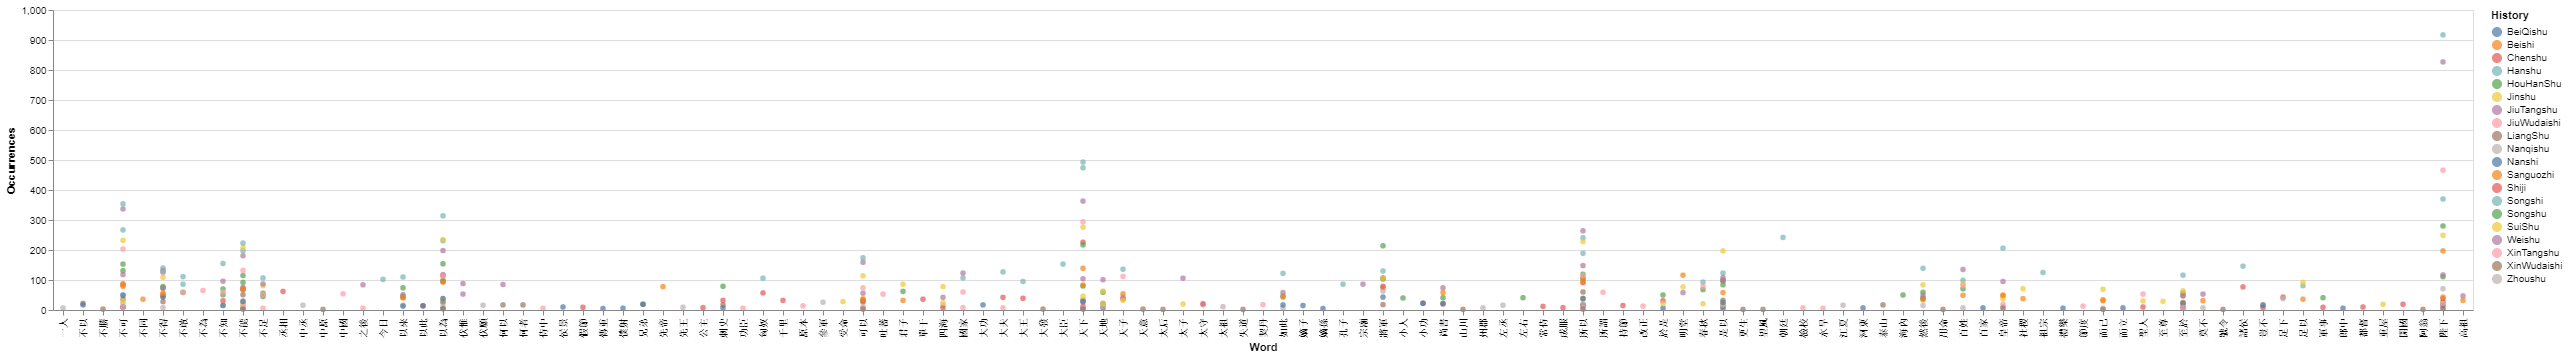

In [262]:
# try to plot most common document words
# this is plotting overlapping vocabulary

alt.Chart(docvocDf).mark_circle().encode(alt.X("Word:N"), alt.Y("Occurrences:Q", sort=alt.EncodingSortField(
field="Occurences", order="descending")), color="History:N", tooltip="History")


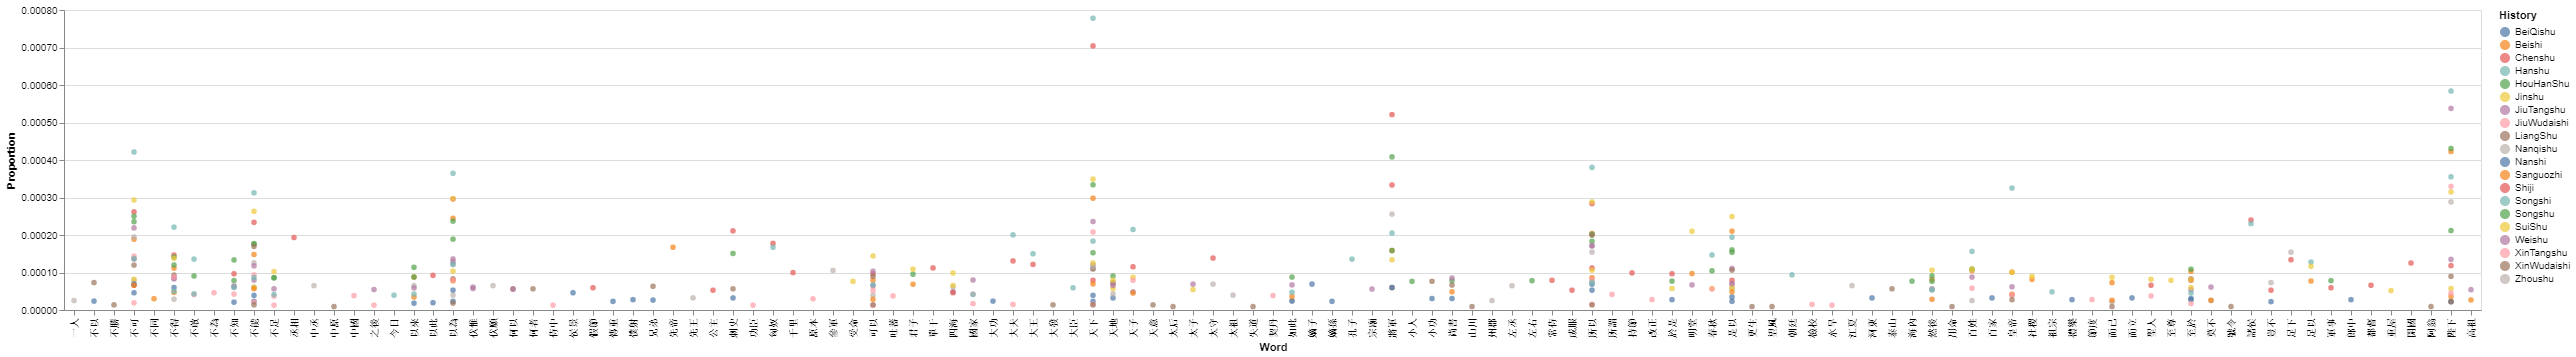

In [263]:
# same as above but with proportion, not occurrences.  

alt.Chart(docvocDf).mark_circle().encode(alt.X("Word:N"), alt.Y("Proportion:Q", sort=alt.EncodingSortField(
field="Occurences", order="descending")), color="History:N", tooltip="History")


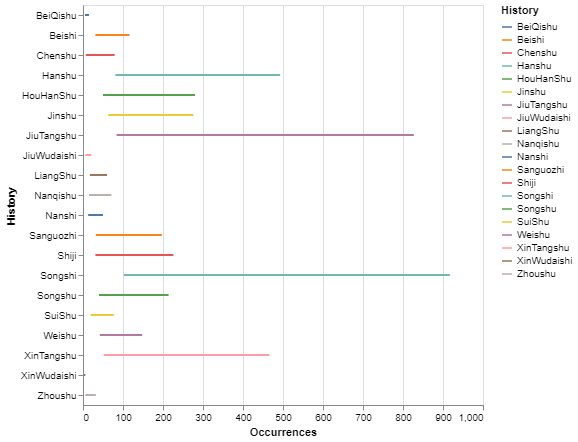

In [264]:
# try again for just the numbers

alt.Chart(docvocDf).mark_line().encode(x="Occurrences:Q", y="History:N", color="History:N", tooltip="History")


In [289]:
docvocDf.head()

,History,Word,Occurrences,Rank,Proportion
0,Shiji,天下,226,1,0.000704
1,Shiji,將軍,107,2,0.000333
2,Shiji,以為,95,3,0.000296
3,Shiji,所以,91,4,0.000284
4,Shiji,不可,84,5,0.000262


In [291]:
# with proportion, not occurrences

propline = alt.Chart(docvocDf).mark_line().encode(alt.X("Proportion:Q", title="Most Common Document Vocabulary, as Proportion of Entire Text"),
                y="History:N", color="History:N", tooltip="Word:N")

propcircles = alt.Chart(docvocDf).mark_circle().encode(alt.X("Proportion:Q", title="Most Common Document Vocabulary, as Proportion of Entire Text"),
                y="History:N", color="History:N", size="Occurrences", tooltip=["Word:N", "Occurrences:O"])

(propline + propcircles).save("TopHistoricalDocumentWords.html") #NB what's being saved.

In [290]:
# as above, but with proportion as circles and raw number as x-axis

occline = alt.Chart(docvocDf).mark_line().encode(alt.X("Occurrences:Q", title="Most Common Document Vocabulary"),
                y="History:N", color="History:N", tooltip="Word:N")

propcircles = alt.Chart(docvocDf).mark_circle().encode(alt.X("Occurrences:Q", title="Most Common Document Vocabulary"),
                y="History:N", color="History:N", size="Proportion", tooltip=["Word:N", "Occurrences:O"])

(occline + propcircles).save("TopHistoricalDocumentWords2.html") #NB what's being saved.

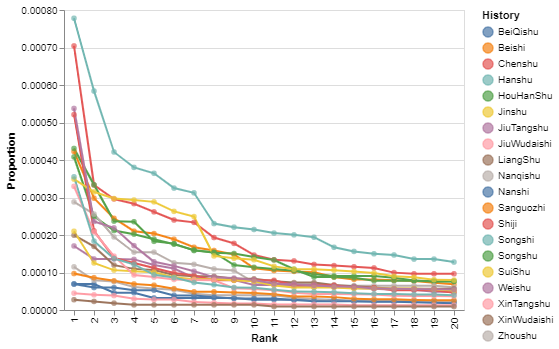

In [266]:
# one more try for a line graph

one = alt.Chart(docvocDf).mark_line().encode(alt.X("Rank:O"), alt.Y("Occurrences:Q"), 
        color="History:N", tooltip=["Word", "History", "Rank"])

two = alt.Chart(docvocDf).mark_circle().encode(alt.X("Rank:O"), alt.Y("Occurrences:Q"), 
        color="History:N", tooltip=["Word", "History", "Rank"])

three = alt.Chart(docvocDf).mark_line().encode(alt.X("Rank:O"), alt.Y("Proportion:Q"), 
        color="History:N", tooltip=["Word", "History", "Rank"])

four = alt.Chart(docvocDf).mark_circle().encode(alt.X("Rank:O"), alt.Y("Proportion:Q"), 
        color="History:N", tooltip=["Word", "History", "Rank"])

#one + two
three + four
#alt.LayerChart(one, two)

In [267]:
docvocDf.Proportion.mean()

0.00010235732164246735

In [268]:
book.Vocab2['Reg']['將軍'] + book.Vocab2['Doc']['將軍'] 

720

In [1]:
#EndTime = time.time()
#ElapsedTime = EndTime - BeginTime
#print(f"Total time elapsed: {ElapsedTime:.4f} sec(s)")